<div class="alert alert-success">
<h1>TABLE OF CONTENTS</h1>
</div>

* [Notes](#NOTES)
* [Setup](#SETUP)
* [Modeling Functions](#MODELING-FUNCTIONS)
* [Create Training and Test Sets](#CREATE-TRAINING-AND-TEST-SETS)
* [Logistic Regression](#LOGISTIC-REGRESSION)
* [KNN](#KNN)
* [Random Forests](#RANDOM-FORESTS)
* [SVC](#SVC)

<div class="alert alert-success">
<h1>NOTES</h1>
</div>

There are 3 sets of columns:

* **sec_cols**: security incident columns (outcome variables)
    * values = -1 (no), 1 (yes), and 0 (NA)
* **dem_cols**: demographic info columns (predictor variables)
* **hab_cols**: security habit columns (predictor variables)

<div class="alert alert-success">
<h1>SETUP</h1>
</div>

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Read in data

In [2]:
df = pd.read_csv('cybersecurity_clean_31Jul17.txt', sep = '\t', encoding = 'utf8')

## Create age groups

In [3]:
for i in range(0,len(df.age)):
    j = df.loc[i,'age']
    if(j >= 1) & (j <= 20): df.loc[i,'age_group'] = '1-20'
    elif(j >= 21) & (j <= 30): df.loc[i,'age_group'] = '21-30'
    elif(j >= 31) & (j <= 40): df.loc[i,'age_group'] = '31-40'
    elif(j >= 41) & (j <= 50): df.loc[i,'age_group'] = '41-50'
    elif(j >= 51) & (j <= 60): df.loc[i,'age_group'] = '51-60'
    elif(j >= 61) & (j <= 70): df.loc[i,'age_group'] = '61-70'
    elif(j >= 71) & (j <= 80): df.loc[i,'age_group'] = '71-80'
    elif(j >= 81): df.loc[i,'age_group'] = '81+'
    else: df.loc[i,'age_group'] = 'other'

## Create income groups

In [4]:
for i in range(0,len(df.inc)):
    j = df.loc[i,'inc']
    if(j == 1): df.loc[i,'inc_group'] = '$0-\n10,000'
    elif(j == 2): df.loc[i,'inc_group'] = '$10,000-\n19,999'
    elif(j == 3): df.loc[i,'inc_group'] = '$20,000-\n29,999'
    elif(j == 4): df.loc[i,'inc_group'] = '$30,000-\n39,999'
    elif(j == 5): df.loc[i,'inc_group'] = '$40,000-\n49,999'
    elif(j == 6): df.loc[i,'inc_group'] = '$50,000-\n59,999'
    elif(j == 7): df.loc[i,'inc_group'] = '$75,000-\n99,999'
    elif(j == 8): df.loc[i,'inc_group'] = '$100,000-\n149,999'
    elif(j == 9): df.loc[i,'inc_group'] = '$150,000+'
    else: df.loc[i,'inc_group'] = 'Other'

## Create subset dataframes

In [5]:
sec_cols = [s for s in df.columns if (s.lower().strip().startswith('sec')) |
           (s == 'ID') and
           (s != 'secur1')]
df_sec = df[sec_cols]

print('Security incident variables: ', sec_cols)

Security incident variables:  ['ID', 'secur2a', 'secur2b', 'secur2c', 'secur2d', 'secur2e', 'secur2f', 'secur2g']


In [6]:
exclude = ['habits4a', 'habits4b', 'habits1f', 'habits1fos', 'habits9os', 'habits1cnt']
hab_cols = [s for s in df.columns if (s.lower().strip().startswith('hab')) |
           (s == 'ID') |
           (s.lower().strip().startswith('wifi2')) and 
           (s not in exclude)]
df_hab = df[hab_cols]

print('Security habit variables: ', hab_cols)

Security habit variables:  ['ID', 'habits1a', 'habits1b', 'habits1c', 'habits1d', 'habits1e', 'habits2', 'habits3', 'habits4c', 'habits5', 'habits6', 'habits7', 'habits8', 'habits9', 'habits10', 'habits11', 'habits12', 'wifi2a', 'wifi2b', 'wifi2c', 'wifi2d']


In [7]:
temp = ['sex','age','educ2','hisp','race3m1','marital',
        'par','emplnw3','party','partyln','ideo','inc',
        'usr']
dem_cols = [s for s in df.columns if (s in temp) |
            (s == 'ID')]
df_dem = df[dem_cols]

print('Demographic variables: ', dem_cols)

Demographic variables:  ['ID', 'sex', 'age', 'educ2', 'hisp', 'race3m1', 'marital', 'par', 'emplnw3', 'party', 'partyln', 'ideo', 'inc', 'usr']


## Create dictionary of columns

In [8]:
dict_sec_cols = {'secur2a': 'SSN compromised',
                 'secur2b': 'Other sensitive info compromised',
                 'secur2c': 'Fraudulent charges on credit/debit card',
                 'secur2d': 'Someone took over email',
                 'secur2e': 'Someone took over social media account',
                 'secur2f': 'Someone opened line of credit/applied for loan under name',
                 'secur2g': 'Someone received tax refund under name'}

for key, val in dict_sec_cols.items():
    print(key,val)

secur2a SSN compromised
secur2b Other sensitive info compromised
secur2c Fraudulent charges on credit/debit card
secur2d Someone took over email
secur2e Someone took over social media account
secur2f Someone opened line of credit/applied for loan under name
secur2g Someone received tax refund under name


# Correlations

## Security incident variables

In [9]:
df_sec.corr()

,ID,secur2a,secur2b,secur2c,secur2d,secur2e,secur2f,secur2g
ID,1.000000,0.072080,0.040866,0.072952,0.104097,0.025571,0.000368,0.000181
secur2a,0.072080,1.000000,0.313427,0.184122,0.143392,0.049244,0.261746,0.214680
secur2b,0.040866,0.313427,1.000000,0.332780,0.210134,-0.005351,0.226394,0.050177
secur2c,0.072952,0.184122,0.332780,1.000000,0.187828,0.005934,0.197522,0.067478
secur2d,0.104097,0.143392,0.210134,0.187828,1.000000,0.161101,0.159210,0.071669
secur2e,0.025571,0.049244,-0.005351,0.005934,0.161101,1.000000,0.071255,0.077058
secur2f,0.000368,0.261746,0.226394,0.197522,0.159210,0.071255,1.000000,0.167113
secur2g,0.000181,0.214680,0.050177,0.067478,0.071669,0.077058,0.167113,1.000000


## Security habit variables

In [10]:
df_hab.corr()

,ID,habits1a,habits1b,habits1c,habits1d,habits1e,habits2,habits3,habits4c,habits5,...,habits7,habits8,habits9,habits10,habits11,habits12,wifi2a,wifi2b,wifi2c,wifi2d
ID,1.000000,0.183073,0.040823,0.110087,0.113262,0.136921,0.138584,0.139372,0.042008,0.064479,...,0.088516,0.151842,0.196000,0.157131,0.167480,0.024132,0.018453,0.004635,0.127739,0.132822
habits1a,0.183073,1.000000,0.055674,0.094748,0.088844,0.128422,0.238986,0.510972,0.095607,0.208840,...,-0.024552,0.202567,0.181217,0.197469,0.233134,0.070714,-0.217492,-0.224720,0.012738,0.029241
habits1b,0.040823,0.055674,1.000000,-0.051519,0.081297,0.067287,0.326063,0.259651,0.194989,0.127481,...,-0.096776,0.018599,0.013333,0.143170,0.122541,-0.005790,-0.110265,-0.194280,-0.100717,-0.052179
habits1c,0.110087,0.094748,-0.051519,1.000000,0.122601,0.202593,0.296074,0.113560,0.116470,0.136122,...,0.211228,0.210087,0.206472,0.028803,0.038755,0.012985,0.119003,-0.025907,0.180584,0.200469
habits1d,0.113262,0.088844,0.081297,0.122601,1.000000,0.262554,0.500973,0.115101,0.222221,0.143687,...,0.059604,0.181439,0.161058,0.113946,0.138885,-0.035652,0.037129,0.027421,0.080417,0.143080
habits1e,0.136921,0.128422,0.067287,0.202593,0.262554,1.000000,0.377690,0.055410,0.177683,0.203903,...,0.137085,0.146539,0.123842,0.054136,0.103644,0.000722,0.076992,0.024533,0.128029,0.193178
habits2,0.138584,0.238986,0.326063,0.296074,0.500973,0.377690,1.000000,0.220547,0.267822,0.148345,...,0.063957,0.197127,0.162676,0.113223,0.140825,0.001747,0.021864,-0.052551,0.050082,0.151428
habits3,0.139372,0.510972,0.259651,0.113560,0.115101,0.055410,0.220547,1.000000,0.057213,0.170201,...,-0.182065,0.237070,0.248696,0.271845,0.258158,0.102834,-0.398896,-0.392012,-0.173753,-0.158589
habits4c,0.042008,0.095607,0.194989,0.116470,0.222221,0.177683,0.267822,0.057213,1.000000,0.161064,...,0.044074,0.062927,0.026525,0.117245,0.162461,-0.052224,0.102532,0.039616,0.135923,0.208694
habits5,0.064479,0.208840,0.127481,0.136122,0.143687,0.203903,0.148345,0.170201,0.161064,1.000000,...,0.194327,0.146339,0.157304,0.129403,0.172596,0.003689,0.079722,0.074462,0.226470,0.253709


## Demographic variables

In [11]:
df_dem.corr()

,ID,sex,age,educ2,hisp,race3m1,marital,par,emplnw3,party,partyln,ideo,inc,usr
ID,1.000000,-0.119406,-0.343113,-0.010926,0.103976,0.112147,0.027175,0.106426,-0.204131,-0.005242,0.040151,0.059691,-0.111167,0.113990
sex,-0.119406,1.000000,0.100085,-0.032790,-0.002374,0.048729,-0.003834,-0.013111,0.221449,-0.049019,-0.093035,0.053488,0.005074,-0.043298
age,-0.343113,0.100085,1.000000,0.163559,-0.127582,-0.177774,-0.256278,-0.268125,0.250020,-0.088816,-0.123027,-0.120902,0.211119,-0.091053
educ2,-0.010926,-0.032790,0.163559,1.000000,0.026655,-0.050589,-0.072269,0.004125,-0.018757,-0.053825,-0.026698,-0.092463,0.155940,-0.038071
hisp,0.103976,-0.002374,-0.127582,0.026655,1.000000,0.487058,0.076618,0.127328,-0.023787,0.024166,0.034256,-0.041843,0.016345,0.055148
race3m1,0.112147,0.048729,-0.177774,-0.050589,0.487058,1.000000,0.108447,0.119486,0.032119,0.092149,0.107876,0.029285,-0.082905,0.061872
marital,0.027175,-0.003834,-0.256278,-0.072269,0.076618,0.108447,1.000000,-0.240432,0.144174,0.084820,-0.002562,0.122642,-0.015750,0.058423
par,0.106426,-0.013111,-0.268125,0.004125,0.127328,0.119486,-0.240432,1.000000,-0.224839,0.033337,0.036833,-0.089019,-0.067813,-0.042455
emplnw3,-0.204131,0.221449,0.250020,-0.018757,-0.023787,0.032119,0.144174,-0.224839,1.000000,0.050664,-0.042718,0.010396,0.044492,-0.092209
party,-0.005242,-0.049019,-0.088816,-0.053825,0.024166,0.092149,0.084820,0.033337,0.050664,1.000000,0.461573,0.168174,-0.002514,0.045377


## Security incident variables x Demographic variables

In [12]:
# Function to calculate correlations between columns in two dataframes

def corr(df1, df2):
    n = len(df1)
    v1, v2 = df1.values, df2.values
    sums = np.multiply.outer(v2.sum(0), v1.sum(0))
    stds = np.multiply.outer(v2.std(0), v1.std(0))
    
    return pd.DataFrame((v2.T.dot(v1) - sums / n) / stds / n,
                        df2.columns, df1.columns)

In [13]:
corr(df_dem, df_sec)

,ID,sex,age,educ2,hisp,race3m1,marital,par,emplnw3,party,partyln,ideo,inc,usr
ID,1.000000,-0.119406,-0.343113,-0.010926,0.103976,0.112147,0.027175,0.106426,-0.204131,-0.005242,0.040151,0.059691,-0.111167,0.113990
secur2a,0.072080,-0.030320,-0.035065,-0.008632,0.025851,0.014530,-0.104695,0.079287,-0.089091,0.028590,0.035654,0.023675,-0.022383,0.021950
secur2b,0.040866,0.004734,0.003588,-0.031545,-0.057366,-0.106956,-0.154279,0.055819,-0.119232,-0.007301,-0.027898,0.063029,-0.038112,0.050394
secur2c,0.072952,-0.046588,0.002489,0.003524,-0.090925,-0.118831,-0.203682,0.044959,-0.166174,-0.039088,0.072154,0.051133,-0.002749,0.080112
secur2d,0.104097,-0.002071,-0.147863,-0.039613,0.023180,-0.006598,-0.024650,0.125619,-0.144305,0.011587,0.038981,0.060056,-0.050390,0.017205
secur2e,0.025571,0.066730,-0.038598,-0.014350,0.067735,0.043507,0.135979,-0.055915,0.062612,-0.021987,-0.027047,0.021751,-0.025550,-0.018430
secur2f,0.000368,0.007001,0.028736,-0.028114,0.048383,0.036955,-0.043536,0.026722,-0.007297,0.002093,0.010621,0.003048,0.013215,0.015216
secur2g,0.000181,0.033695,0.058045,0.001262,0.036077,0.008052,0.006507,-0.017757,0.039903,-0.021220,-0.000901,0.013184,-0.013529,-0.003001


## Security incident variables x Security habit variables

In [14]:
corr(df_hab, df_sec)

,ID,habits1a,habits1b,habits1c,habits1d,habits1e,habits2,habits3,habits4c,habits5,...,habits7,habits8,habits9,habits10,habits11,habits12,wifi2a,wifi2b,wifi2c,wifi2d
ID,1.000000,0.183073,0.040823,0.110087,0.113262,0.136921,0.138584,0.139372,0.042008,0.064479,...,0.088516,0.151842,0.196000,0.157131,0.167480,0.024132,0.018453,0.004635,0.127739,0.132822
secur2a,0.072080,0.014996,0.024304,0.079987,0.007166,0.000794,0.050720,0.048192,0.069716,0.069366,...,0.014839,0.097182,0.107420,0.088302,0.079532,0.062710,0.003550,-0.007899,0.016219,0.065232
secur2b,0.040866,0.079479,0.062333,0.056242,0.084433,0.031960,0.125076,0.110201,0.146549,0.141250,...,0.018873,0.098475,0.080589,0.090738,0.062301,0.085787,0.023264,0.001006,0.065446,0.109405
secur2c,0.072952,0.085183,0.074544,0.093321,0.074937,0.054730,0.113237,0.140331,0.135357,0.116328,...,0.051354,0.136347,0.113375,0.093041,0.123850,0.019965,0.023707,-0.028231,0.063653,0.113082
secur2d,0.104097,0.141824,0.051424,0.100096,0.095092,0.142836,0.113582,0.140649,0.122851,0.121390,...,0.068926,0.120652,0.136967,0.060746,0.051788,0.074566,-0.000928,-0.036413,0.060873,0.052463
secur2e,0.025571,-0.184295,-0.100139,0.003569,0.038374,0.014606,-0.020672,-0.281991,-0.005471,-0.033966,...,0.211011,-0.018368,0.026638,-0.139129,-0.105102,0.048604,0.163846,0.153177,0.138271,0.039319
secur2f,0.000368,-0.048391,-0.025437,-0.019109,0.016545,0.013228,0.047447,-0.006194,0.045859,-0.043040,...,-0.013140,-0.010075,0.018298,0.029252,-0.012681,0.063624,0.053571,0.025124,-0.029764,0.004025
secur2g,0.000181,-0.061285,0.033503,0.008841,-0.002233,0.013687,-0.018018,-0.078129,0.013064,-0.034826,...,-0.012401,-0.071232,-0.055527,-0.024432,-0.046423,0.017813,-0.004281,-0.016321,-0.027180,-0.038973


<div class="alert alert-success">
<h1>MODELING FUNCTIONS</h1>
</div>

### Function: cv_optimize (cross-validation)
**Input**
- Classifier ('clf')
- Grid of hyperparameters implemented as a dictionary ('parameters')
- Training set, as a samples x features array ('XTrain')
- Set of labels ('ytrain)

**Function**

Takes the training set, splits it into `n_folds` parts, sets up `n_folds` folds, and carries out a cross-validation by splitting the training set into a training and validation section for each fold for us

**Output**
- Prints the best value of the parameters
- Returns the best classifier ('best')

In [15]:
from sklearn.model_selection import GridSearchCV

def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds, scorer):

    gs = GridSearchCV(clf,
                      param_grid = parameters,
                      cv = n_folds,
                      scoring = scorer) 
    
    gs.fit(Xtrain, ytrain)
    
    print('\tBest Parameters: ' + str(gs.best_params_))
    print('\tScoring method used: ' + str(gs.scorer_) + ')')
    
    return gs.best_estimator_, gs.best_params_

### do_classify
**Input**
- Classifier ('clf')
- Parameters, such as regularization parameter ('parameters')
- Dataframe containing features and target ('in_df')
- List of columns to use as features ('feature_names')
- Column to use as target ('targetname')
- Value to use as target - will be set to 1; all others will be set to 0 ('targetlval')
- Boolean to indicate whether to standardize data ('standardize')
- Boolean to indicate whether to use stratified sampling for cross-validation ('strat')

**Function**
- Splits dataframe into 75% training and 25% test
- Standardizes the dataset if desired (scales the data so that it has a mean of 0 and is described in units of its SD)
- Trains model on training set using cross-validation
- Uses cv_optimize to obtain best classifier and then re-trains on entire training set

**Output**
- Returns split data and trained classifier

In [16]:
from sklearn.model_selection import train_test_split

def do_classify(clf, parameters, df, x_col_set, feature_names, targetname, scorer, mod_results, clf_str):
    
    n_folds = 5
    
    """Get training and test sets"""
    key = 'ytrain_' + targetname + '_' + x_col_set
    ytrain = tt_dict[key]
    
    key = 'ytest_' + targetname + '_' + x_col_set
    ytest = tt_dict[key]
    
    key = 'Xtrain_' + targetname + '_' + x_col_set
    Xtrain = tt_dict[key]
    
    key = 'Xtest_' + targetname + '_' + x_col_set
    Xtest = tt_dict[key]
    
    """Identify classes"""
    classes = np.unique(ytrain)
    
    unique, counts = np.unique(ytrain, return_counts=True)
    print('\tClasses in ytrain: ' + str(dict(zip(unique, counts))))
    
    unique, counts = np.unique(ytest, return_counts=True)
    print('\tClasses in ytest: ' + str(dict(zip(unique, counts))))
        
    """Create and fit model"""
    clf, best_params = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds, scorer)
    clf = clf.fit(Xtrain, ytrain)

    """Evaluate model"""
    # with train data:
    acc_train, acc_test, precision_train, recall_train, f1_train, cohenk_train, auc_train = model_eval(clf,
                                                                                            Xtrain,
                                                                                            Xtest,
                                                                                            ytrain,
                                                                                            ytest,
                                                                                            feature_names,
                                                                                            classes,
                                                                                            'train',
                                                                                            targetname)
    
    # with test data:
    acc_train,acc_test, precision_test, recall_test, f1_test, cohenk_test, auc_test = model_eval(clf,
                                                                                        Xtrain,
                                                                                        Xtest,
                                                                                        ytrain,
                                                                                        ytest,
                                                                                        feature_names,
                                                                                        classes,
                                                                                        'test',
                                                                                        targetname) 

    """Save results of model eval"""  
    mod_results = model_results(clf_str,
                                targetname,
                                x_col_set,
                                scorer,
                                best_params,
                                acc_train,
                                acc_test,
                                precision_train,
                                recall_train,
                                f1_train,
                                cohenk_train,
                                auc_train,
                                precision_test,
                                recall_test,
                                f1_test,
                                cohenk_test,
                                auc_test,
                                mod_results)
    
    return mod_results

### Plot confusion matrix
Prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`

In [17]:
import itertools

def plot_confusion_matrix(cm, classes, normalize, cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Confusion matrix, with normalization'
    else:
        title = 'Confusion matrix, without normalization'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Calculate proportion in classes
Given a dataframe and column, prints number of observations per class in column and proportion of total observations

In [18]:
def calc_prop_class(df, col):
    classes = df[col].unique()
    for c in classes:
        num_obs = sum(df[col] == c)
        total_obs = len(df[col])
        prop = round((num_obs / total_obs),2)
        print('\tObservations in class ' + str(c) + ': ' + str(num_obs) + ' (' + str(prop) + '%)')    

### Perform model evaluation
Calculates and prints precision, recall, F1-score, cohen's kappa, feature importance, and confusion matrix

In [19]:
from sklearn import metrics

def model_eval(clf, Xtrain, Xtest, ytrain, ytest, feature_names, classes, test_or_train, y_col):
    
    """ ======= CALCULATE TRAINING AND TEST ACCURACY ======= """
    
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    
    print('\tAccuracy on training data: {:0.2f}'.format(training_accuracy))
    print('\tAccuracy on test data:     {:0.2f}'.format(test_accuracy))
        
    """ ======= CALCULATE PRECISION, RECALL, F1-SCORE, AND COHEN'S KAPPA ======= """

    if test_or_train == 'test':
        ypred = clf.predict(Xtest)
        try:
            ypred_proba = clf.predict_proba(Xtest)
            prob = True
        except:
            prob = False
        ytrue = ytest
        print('\t\nMETRICS FOR TEST DATA')
    else:
        ypred = clf.predict(Xtrain)
        try:
            ypred_proba = clf.predict_proba(Xtrain)
            prob = True
        except:
            prob = False
        ytrue = ytrain
        print('\t\nMETRICS FOR TRAINING DATA')
        
    # set average method for metrics
    if len(classes) == 2:
        average_param = 'binary'
    else:
        average_param = 'weighted'
    
    precision = metrics.precision_score(ytrue, ypred, average=average_param)
    
    recall = metrics.recall_score(ytrue, ypred, average=average_param)
    
    f1 = metrics.f1_score(ytrue, ypred, average=average_param)
    
    cohenk = metrics.cohen_kappa_score(ytrue, ypred)
    
    if prob == True:
        auc = metrics.roc_auc_score(ytrue, ypred_proba[:,1])
    else:
        auc = -999
    
    print('\tPrecision: ' + str(round(precision,2)))
    print('\tRecall: ' + str(round(recall,2))) 
    print('\tF1 Score: ' + str(round(f1,2)))
    print('\tCohen\'s Kappa: ' + str(round(cohenk,2)))
    if prob == True:
        print('\tAUC: ' + str(round(auc,2)))
    
    """ ======= GRAPH FEATURE IMPORTANCE ======= """
    
    if test_or_train == 'test':
        if hasattr(clf, 'feature_importances_'):
            graph_feature_import(clf, feature_names, Xtrain, 'feat_imp', y_col)
        elif hasattr(clf, 'coef_'):
            graph_feature_import(clf, feature_names, Xtrain, 'coef', y_col)

    """ ======= CREATE CONFUSION MATRIX ======= """
    
    cnf_matrix = metrics.confusion_matrix(ytrue, ypred)
    np.set_printoptions(precision=2)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes, False)
    plt.show()
    
    return training_accuracy, test_accuracy, precision, recall, f1, cohenk, auc

### Store results in dataframe

In [20]:
def model_results(clf_str, yname, Xname, scorer, best_params, acc_train, acc_test,
                  precision_train, recall_train, f1_train, cohenk_train, auc_train,
                  precision_test, recall_test, f1_test, cohenk_test, auc_test, mod_results):
    
    if str(scorer) == 'make_scorer(cohen_kappa_score)':
        scorer_str = 'cohenk'
    else:
        scorer_str = str(scorer)
    
    dict_metrics = {}
    dict_metrics['clf'] = clf_str
    dict_metrics['y'] = yname
    dict_metrics['X'] = Xname
    dict_metrics['score_meth'] = scorer_str
    dict_metrics['best_params'] = best_params
    dict_metrics['acc_train'] = round(acc_train,2)
    dict_metrics['acc_test'] = round(acc_test,2)
    dict_metrics['precision_train'] = round(precision_train,2)
    dict_metrics['recall_train'] = round(recall_train,2)
    dict_metrics['f1_train'] = round(f1_train,2)
    dict_metrics['cohenk_train'] = round(cohenk_train,2)
    dict_metrics['auc_train'] = round(auc_train,2)
    dict_metrics['precision_test'] = round(precision_test,2)
    dict_metrics['recall_test'] = round(recall_test,2)
    dict_metrics['f1_test'] = round(f1_test,2)
    dict_metrics['cohenk_test'] = round(cohenk_test,2)
    dict_metrics['auc_test'] = round(auc_test,2)

    mod_results.append(dict_metrics)
    
    return mod_results

### Plot feature importance
Plots the clf feature importances

In [21]:
def graph_feature_import(clf, features, Xtrain, graph_type, y_col):
        
    if graph_type == 'feat_imp':
        
        df_graph = pd.DataFrame(clf.feature_importances_,
                                index=features, 
                                columns=['Importance'])

        df_graph['Std'] = np.std([clf.feature_importances_
                                for est in clf.estimators_], axis=0)
        
        df_graph2 = df_graph.sort_values(by = 'Importance', ascending = False)
        
        print('\t\nFeature importances for ' + str(y_col) + '\n')
        print(df_graph2)
        
        x = range(df_graph2.shape[0])
        y = df_graph2.ix[:, 0]
        yerr = df_graph2.ix[:, 1]
        
        plt.bar(x, y, yerr=yerr, align='center')
        plt.xticks(np.arange(min(x), max(x)+1, 1))    
        plt.xticks(x, df_graph2.index, rotation='vertical')
        plt.title('Feature importance')
        
        plt.show()

    elif graph_type == 'coef':
        
        coefs = np.std(Xtrain, 0)*clf.coef_
        coefs = pd.Series(coefs[0])
        
        df_graph = pd.DataFrame({'Feature': features,
                                 'Coefficient': coefs,
                                 'Coeff_AV': abs(coefs)})
        
        # sort dataframe by absolute value of coefficients
        df_graph2 = df_graph.sort_values(by = 'Coeff_AV', ascending = False)
        
        print('\t\nStandardized coefficients for ' + str(y_col) + '\n')
        print(df_graph2)
        
        x = range(df_graph2.shape[0])
        y = df_graph2['Coeff_AV']
        
        plt.bar(x, y, align='center')
        plt.xticks(np.arange(min(x), max(x)+1, 1))    
        plt.xticks(x, df_graph2['Feature'], rotation='vertical')
        title = 'Absolute Value of Standardized Coefficients for ' + str(y_col)
        plt.title(title)

        plt.show()

### Reorder columns for results dataframe

In [22]:
def reorder_cols(df):
    
    df = df[['y', 'X', 'clf', 'best_params', 'score_meth', 'acc_train',
             'precision_train', 'recall_train', 'f1_train', 'cohenk_train', 'auc_train',
             'acc_test', 'precision_test', 'recall_test', 'f1_test', 'cohenk_test', 'auc_test']]
    
    return df

### Create final results dataframe

In [23]:
def create_final_df():
    cols = ['y', 'X', 'clf', 'best_params', 'score_meth', 'acc_train',
            'precision_train', 'recall_train', 'f1_train', 'cohenk_train', 'auc_train',
            'acc_test', 'precision_test', 'recall_test', 'f1_test', 'cohenk_test', 'auc_test']
    
    df_mod_results = pd.DataFrame(columns = cols)
    return df_mod_results

### Print class distribution for each y variable

In [24]:
for y_col in sec_cols:
    if y_col != 'ID':
        print('\nY = ' + y_col.upper() + ' (' + dict_sec_cols[y_col] + ')')
        calc_prop_class(df, y_col)


Y = SECUR2A (SSN compromised)
	Observations in class -1: 867 (0.83%)
	Observations in class 1: 167 (0.16%)
	Observations in class 0: 6 (0.01%)

Y = SECUR2B (Other sensitive info compromised)
	Observations in class 1: 402 (0.39%)
	Observations in class -1: 628 (0.6%)
	Observations in class 0: 10 (0.01%)

Y = SECUR2C (Fraudulent charges on credit/debit card)
	Observations in class 1: 475 (0.46%)
	Observations in class -1: 561 (0.54%)
	Observations in class 0: 4 (0.0%)

Y = SECUR2D (Someone took over email)
	Observations in class 1: 175 (0.17%)
	Observations in class -1: 855 (0.82%)
	Observations in class 0: 10 (0.01%)

Y = SECUR2E (Someone took over social media account)
	Observations in class -1: 798 (0.77%)
	Observations in class 0: 119 (0.11%)
	Observations in class 1: 123 (0.12%)

Y = SECUR2F (Someone opened line of credit/applied for loan under name)
	Observations in class -1: 871 (0.84%)
	Observations in class 1: 153 (0.15%)
	Observations in class 0: 16 (0.02%)

Y = SECUR2G (Someo

<div class="alert alert-success">
<h1>CREATE TRAINING AND TEST SETS</h1>
</div>

In [25]:
import os 

def create_train_test(tt_dict):

    # set variables
    target1val = 1
    strat = True
    x_cols_name = ['dem','hab']

    # iterate through X columns
    for x_col_set in x_cols_name:

        # assign X cols
        if x_col_set == 'dem':
            x_cols = dem_cols[1:]
        else:
            x_cols = hab_cols[1:]

        # iterate through y columns
        for y_col in sec_cols:

            if y_col != 'ID':

                # set file names
                ytrain_file = './training_test_sets/ytrain_' + y_col + '_' + x_col_set + '.txt'
                ytest_file = './training_test_sets/ytest_' + y_col + '_' + x_col_set + '.txt'
                Xtrain_file = './training_test_sets/Xtrain_' + y_col + '_' + x_col_set + '.txt'
                Xtest_file = './training_test_sets/Xtest_' + y_col + '_' + x_col_set + '.txt'

                """If training and test sets exist, load them; otherwise, create them"""

                if os.path.isfile(ytrain_file):
                    print('Training and test set files already exist, opening now.')
                    
                    # read in ytrain data
                    ytrain_data = np.loadtxt(ytrain_file, delimiter = '\t')
                    ytrain_data = ytrain_data[1:] # remove header row

                    # read in ytest data
                    ytest_data = np.loadtxt(ytest_file, delimiter = '\t')
                    ytest_data = ytest_data[1:] # remove header row

                    # read in Xtrain data
                    Xtrain_data = np.loadtxt(Xtrain_file, delimiter = '\t')
                    Xtrain_data = Xtrain_data[1:] # remove header row
                    
                    # read in Xtest data
                    Xtest_data = np.loadtxt(Xtest_file, delimiter = '\t')
                    Xtest_data = Xtest_data[1:] # remove header row

                else:               
                    print('Training and test set files do not exist, generating now.')
                    
                    # remove rows where y_col is don't know/refused (0)
                    clf_df = df[df[y_col] != 0]        

                    sub_df = clf_df[x_cols]

                    # X = df with feature columns
                    X = sub_df.values

                    # convert y values to 1s and 0s
                    y = (clf_df[y_col].values == target1val)*1
                    
                    # create training and test sets
                    if strat == True:
                        Xtrain_data, Xtest_data, ytrain_data, ytest_data = train_test_split(X, y, stratify=y)
                    else:
                        Xtrain_data, Xtest_data, ytrain_data, ytest_data = train_test_split(X, y)      
                        
                # add ytrain data to dictionary and save to csv
                key = 'ytrain_' + y_col + '_' + x_col_set
                value = ytrain_data
                tt_dict[key] = value
                value = pd.DataFrame(value)
                value.to_csv(ytrain_file, sep = '\t', index = False)

                # add ytest data to dictionary and save to csv
                key = 'ytest_' + y_col + '_' + x_col_set
                value = ytest_data
                tt_dict[key] = value
                value = pd.DataFrame(value)
                value.to_csv(ytest_file, sep = '\t', index = False)

                # add Xtrain data to dictionary and save to csv
                key = 'Xtrain_' + y_col + '_' + x_col_set
                value = Xtrain_data
                tt_dict[key] = value                 
                value = pd.DataFrame(value)               
                value.to_csv(Xtrain_file, sep = '\t', index = False)

                # add Xtest data to dictionary and save to csv
                key = 'Xtest_' + y_col + '_' + x_col_set
                value = Xtest_data
                tt_dict[key] = value 
                value = pd.DataFrame(value)
                value.to_csv(Xtest_file, sep = '\t', index = False)               
                
    return tt_dict

In [26]:
tt_dict = {}
tt_dict = create_train_test(tt_dict)

Training and test set files already exist, opening now.
Training and test set files already exist, opening now.
Training and test set files already exist, opening now.
Training and test set files already exist, opening now.
Training and test set files already exist, opening now.
Training and test set files already exist, opening now.
Training and test set files already exist, opening now.
Training and test set files already exist, opening now.
Training and test set files already exist, opening now.
Training and test set files already exist, opening now.
Training and test set files already exist, opening now.
Training and test set files already exist, opening now.
Training and test set files already exist, opening now.
Training and test set files already exist, opening now.


<div class="alert alert-success">
<h1>LOGISTIC REGRESSION</h1>
</div>

### Perform logistic regression


Y = SECUR2A (SSN compromised)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0.0: 650, 1.0: 125}
	Classes in ytest: {0.0: 217, 1.0: 42}
	Best Parameters: {'C': 0.01, 'class_weight': {0: 0.2, 1: 0.8}, 'fit_intercept': False}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.81
	Accuracy on test data:     0.80
	
METRICS FOR TRAINING DATA
	Precision: 0.24
	Recall: 0.1
	F1 Score: 0.14
	Cohen's Kappa: 0.05
	AUC: 0.59


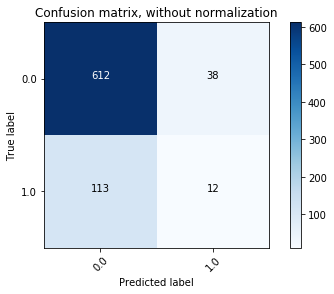

	Accuracy on training data: 0.81
	Accuracy on test data:     0.80
	
METRICS FOR TEST DATA
	Precision: 0.26
	Recall: 0.14
	F1 Score: 0.18
	Cohen's Kappa: 0.08
	AUC: 0.62
	
Standardized coefficients for secur2a

    Coeff_AV  Coefficient  Feature
5   0.166504    -0.166504  marital
11  0.059697    -0.059697      inc
0   0.057623    -0.057623      sex
10  0.051228     0.051228     ideo
1   0.046269    -0.046269      age
6   0.042003     0.042003      par
7   0.026957    -0.026957  emplnw3
12  0.019294     0.019294      usr
2   0.011689    -0.011689    educ2
8   0.008695    -0.008695    party
9   0.004137     0.004137  partyln
4   0.003456     0.003456  race3m1
3   0.002866     0.002866     hisp


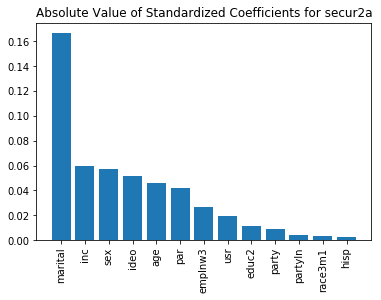

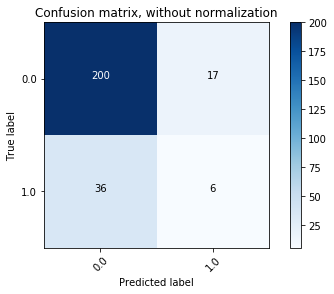


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0.0: 650, 1.0: 125}
	Classes in ytest: {0.0: 217, 1.0: 42}
	Best Parameters: {'C': 1e-06, 'class_weight': {0: 0.2, 1: 0.8}, 'fit_intercept': False}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.83
	Accuracy on test data:     0.84
	
METRICS FOR TRAINING DATA
	Precision: 0.36
	Recall: 0.08
	F1 Score: 0.13
	Cohen's Kappa: 0.08
	AUC: 0.53


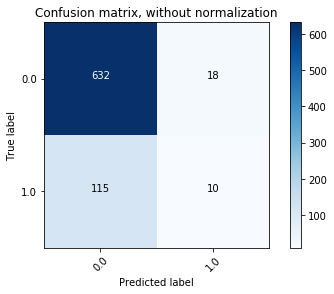

	Accuracy on training data: 0.83
	Accuracy on test data:     0.84
	
METRICS FOR TEST DATA
	Precision: 0.5
	Recall: 0.05
	F1 Score: 0.09
	Cohen's Kappa: 0.06
	AUC: 0.63
	
Standardized coefficients for secur2a

    Coeff_AV  Coefficient   Feature
13  0.000018    -0.000018  habits10
8   0.000015     0.000015   habits5
9   0.000014     0.000014   habits6
6   0.000012    -0.000012   habits3
2   0.000011     0.000011  habits1c
15  0.000010     0.000010  habits12
11  0.000009     0.000009   habits8
12  0.000008     0.000008   habits9
7   0.000008     0.000008  habits4c
14  0.000008    -0.000008  habits11
3   0.000007     0.000007  habits1d
10  0.000007     0.000007   habits7
19  0.000007     0.000007    wifi2d
5   0.000007    -0.000007   habits2
17  0.000006     0.000006    wifi2b
4   0.000006     0.000006  habits1e
16  0.000005     0.000005    wifi2a
1   0.000003     0.000003  habits1b
18  0.000003     0.000003    wifi2c
0   0.000003    -0.000003  habits1a


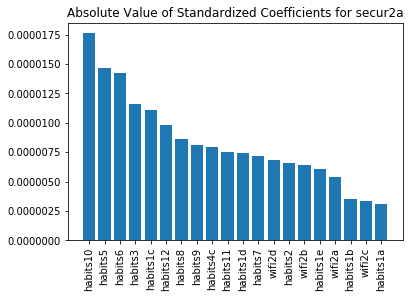

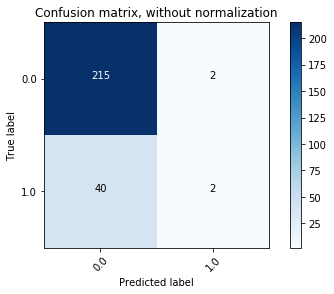


Y = SECUR2B (Other sensitive info compromised)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0.0: 471, 1.0: 301}
	Classes in ytest: {0.0: 157, 1.0: 101}
	Best Parameters: {'C': 0.01, 'class_weight': {0: 0.4, 1: 0.6}, 'fit_intercept': False}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.59
	Accuracy on test data:     0.57
	
METRICS FOR TRAINING DATA
	Precision: 0.48
	Recall: 0.59
	F1 Score: 0.53
	Cohen's Kappa: 0.17
	AUC: 0.62


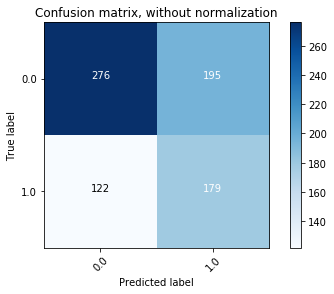

	Accuracy on training data: 0.59
	Accuracy on test data:     0.57
	
METRICS FOR TEST DATA
	Precision: 0.46
	Recall: 0.57
	F1 Score: 0.51
	Cohen's Kappa: 0.14
	AUC: 0.64
	
Standardized coefficients for secur2b

    Coeff_AV  Coefficient  Feature
5   0.193684    -0.193684  marital
4   0.139627    -0.139627  race3m1
11  0.106799    -0.106799      inc
10  0.096499     0.096499     ideo
7   0.068272    -0.068272  emplnw3
1   0.049863     0.049863      age
12  0.046169     0.046169      usr
9   0.039720    -0.039720  partyln
6   0.027147     0.027147      par
8   0.025696     0.025696    party
2   0.020079     0.020079    educ2
3   0.005214    -0.005214     hisp
0   0.003757     0.003757      sex


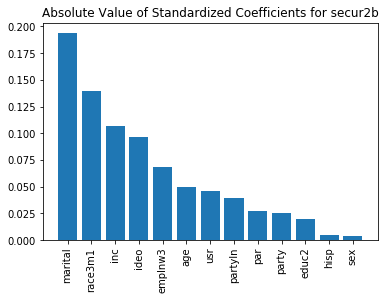

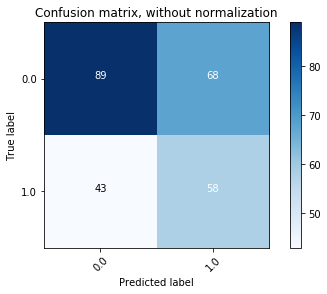


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0.0: 471, 1.0: 301}
	Classes in ytest: {0.0: 157, 1.0: 101}
	Best Parameters: {'C': 10, 'class_weight': {0: 0.4, 1: 0.6}, 'fit_intercept': False}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.62
	Accuracy on test data:     0.60
	
METRICS FOR TRAINING DATA
	Precision: 0.52
	Recall: 0.57
	F1 Score: 0.54
	Cohen's Kappa: 0.23
	AUC: 0.67


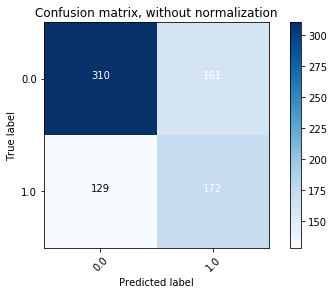

	Accuracy on training data: 0.62
	Accuracy on test data:     0.60
	
METRICS FOR TEST DATA
	Precision: 0.49
	Recall: 0.61
	F1 Score: 0.54
	Cohen's Kappa: 0.19
	AUC: 0.63
	
Standardized coefficients for secur2b

    Coeff_AV  Coefficient   Feature
7   0.280029     0.280029  habits4c
9   0.253685     0.253685   habits6
6   0.191600     0.191600   habits3
8   0.157396     0.157396   habits5
15  0.134442     0.134442  habits12
19  0.126595     0.126595    wifi2d
4   0.106605    -0.106605  habits1e
5   0.087185     0.087185   habits2
13  0.084815     0.084815  habits10
16  0.080763     0.080763    wifi2a
3   0.073271     0.073271  habits1d
1   0.069207    -0.069207  habits1b
0   0.046366    -0.046366  habits1a
12  0.045540    -0.045540   habits9
14  0.036356    -0.036356  habits11
10  0.026937    -0.026937   habits7
18  0.021033    -0.021033    wifi2c
17  0.014486     0.014486    wifi2b
11  0.004042     0.004042   habits8
2   0.002647    -0.002647  habits1c


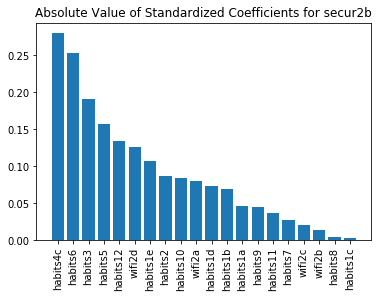

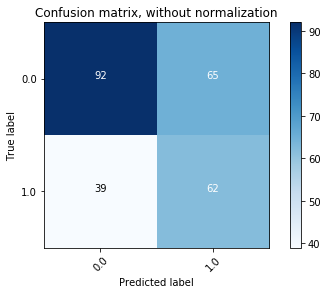


Y = SECUR2C (Fraudulent charges on credit/debit card)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0.0: 421, 1.0: 356}
	Classes in ytest: {0.0: 140, 1.0: 119}
	Best Parameters: {'C': 0.1, 'class_weight': {0: 0.5, 1: 0.5}, 'fit_intercept': False}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.63
	Accuracy on test data:     0.59
	
METRICS FOR TRAINING DATA
	Precision: 0.61
	Recall: 0.56
	F1 Score: 0.59
	Cohen's Kappa: 0.26
	AUC: 0.69


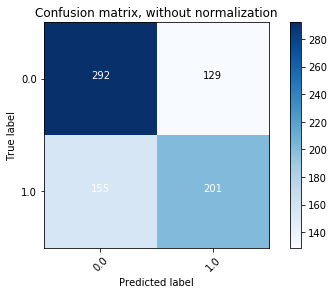

	Accuracy on training data: 0.63
	Accuracy on test data:     0.59
	
METRICS FOR TEST DATA
	Precision: 0.56
	Recall: 0.54
	F1 Score: 0.55
	Cohen's Kappa: 0.18
	AUC: 0.64
	
Standardized coefficients for secur2c

    Coeff_AV  Coefficient  Feature
5   0.454894    -0.454894  marital
4   0.214513    -0.214513  race3m1
12  0.204032     0.204032      usr
7   0.200380    -0.200380  emplnw3
10  0.174490     0.174490     ideo
9   0.166890     0.166890  partyln
8   0.099482    -0.099482    party
3   0.050245    -0.050245     hisp
1   0.047305     0.047305      age
2   0.035849    -0.035849    educ2
0   0.026620     0.026620      sex
6   0.018217     0.018217      par
11  0.010126     0.010126      inc


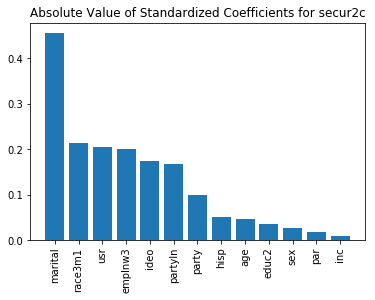

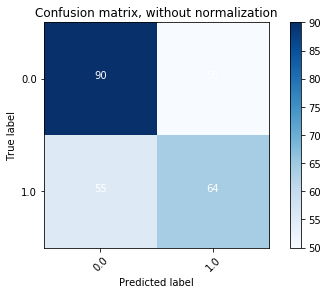


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0.0: 421, 1.0: 356}
	Classes in ytest: {0.0: 140, 1.0: 119}
	Best Parameters: {'C': 0.01, 'class_weight': {0: 0.4, 1: 0.6}, 'fit_intercept': False}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.58
	Accuracy on test data:     0.58
	
METRICS FOR TRAINING DATA
	Precision: 0.53
	Recall: 0.82
	F1 Score: 0.64
	Cohen's Kappa: 0.2
	AUC: 0.65


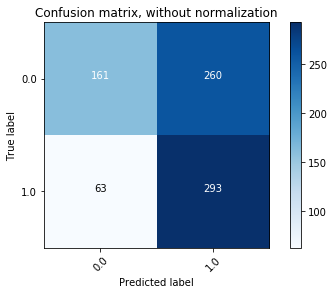

	Accuracy on training data: 0.58
	Accuracy on test data:     0.58
	
METRICS FOR TEST DATA
	Precision: 0.53
	Recall: 0.87
	F1 Score: 0.66
	Cohen's Kappa: 0.2
	AUC: 0.64
	
Standardized coefficients for secur2c

    Coeff_AV  Coefficient   Feature
9   0.137673     0.137673   habits6
7   0.093609     0.093609  habits4c
6   0.082023     0.082023   habits3
5   0.067496     0.067496   habits2
8   0.064815     0.064815   habits5
14  0.062993     0.062993  habits11
13  0.059593     0.059593  habits10
11  0.044618     0.044618   habits8
19  0.041266     0.041266    wifi2d
1   0.033940     0.033940  habits1b
16  0.017970     0.017970    wifi2a
12  0.017074     0.017074   habits9
4   0.016520    -0.016520  habits1e
3   0.016258     0.016258  habits1d
18  0.013667     0.013667    wifi2c
17  0.013179    -0.013179    wifi2b
15  0.012295     0.012295  habits12
0   0.009493     0.009493  habits1a
2   0.006213     0.006213  habits1c
10  0.002843     0.002843   habits7


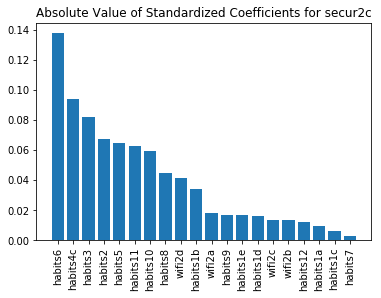

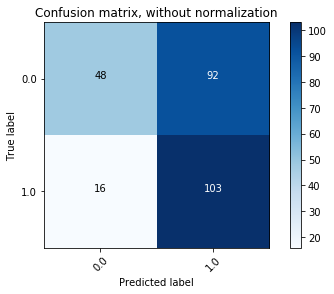


Y = SECUR2D (Someone took over email)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0.0: 641, 1.0: 131}
	Classes in ytest: {0.0: 214, 1.0: 44}
	Best Parameters: {'C': 0.01, 'class_weight': {0: 0.2, 1: 0.8}, 'fit_intercept': False}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.74
	Accuracy on test data:     0.76
	
METRICS FOR TRAINING DATA
	Precision: 0.29
	Recall: 0.36
	F1 Score: 0.32
	Cohen's Kappa: 0.16
	AUC: 0.64


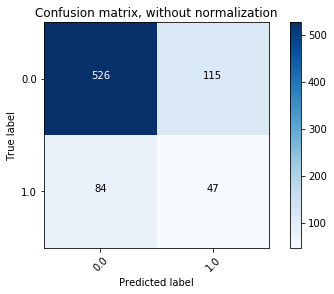

	Accuracy on training data: 0.74
	Accuracy on test data:     0.76
	
METRICS FOR TEST DATA
	Precision: 0.28
	Recall: 0.27
	F1 Score: 0.28
	Cohen's Kappa: 0.13
	AUC: 0.64
	
Standardized coefficients for secur2d

    Coeff_AV  Coefficient  Feature
1   0.169675    -0.169675      age
10  0.138179     0.138179     ideo
11  0.114981    -0.114981      inc
2   0.103761    -0.103761    educ2
7   0.075269    -0.075269  emplnw3
6   0.071662     0.071662      par
9   0.029340     0.029340  partyln
8   0.028308     0.028308    party
4   0.026972    -0.026972  race3m1
12  0.025803     0.025803      usr
0   0.017110     0.017110      sex
3   0.004001    -0.004001     hisp
5   0.001761    -0.001761  marital


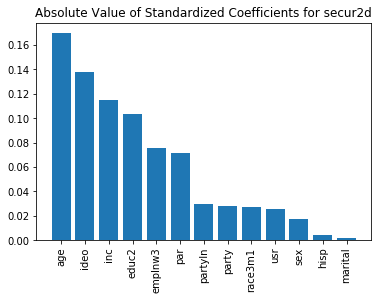

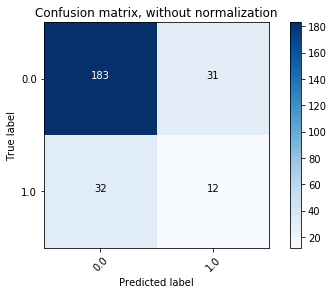


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0.0: 641, 1.0: 131}
	Classes in ytest: {0.0: 214, 1.0: 44}
	Best Parameters: {'C': 1e-06, 'class_weight': {0: 0.2, 1: 0.8}, 'fit_intercept': False}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.66
	Accuracy on test data:     0.62
	
METRICS FOR TRAINING DATA
	Precision: 0.27
	Recall: 0.57
	F1 Score: 0.37
	Cohen's Kappa: 0.18
	AUC: 0.7


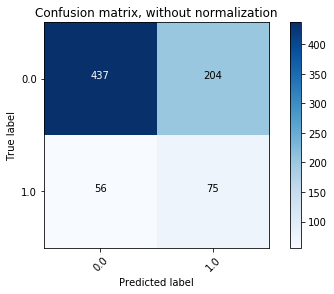

	Accuracy on training data: 0.66
	Accuracy on test data:     0.62
	
METRICS FOR TEST DATA
	Precision: 0.25
	Recall: 0.61
	F1 Score: 0.35
	Cohen's Kappa: 0.15
	AUC: 0.64
	
Standardized coefficients for secur2d

        Coeff_AV   Coefficient   Feature
12  3.772615e-05  3.772615e-05   habits9
9   2.536879e-05  2.536879e-05   habits6
8   2.066389e-05  2.066389e-05   habits5
11  1.814964e-05  1.814964e-05   habits8
7   1.747110e-05  1.747110e-05  habits4c
18  1.335759e-05  1.335759e-05    wifi2c
10  1.328089e-05  1.328089e-05   habits7
3   1.310963e-05  1.310963e-05  habits1d
15  1.260868e-05  1.260868e-05  habits12
4   1.221497e-05  1.221497e-05  habits1e
2   1.165065e-05  1.165065e-05  habits1c
0   1.119601e-05  1.119601e-05  habits1a
19  9.076456e-06  9.076456e-06    wifi2d
1   7.465672e-06  7.465672e-06  habits1b
6   5.827526e-06  5.827526e-06   habits3
5   5.673252e-06  5.673252e-06   habits2
16  4.092991e-06  4.092991e-06    wifi2a
17  2.726775e-06  2.726775e-06    wifi2b
14  1.57920

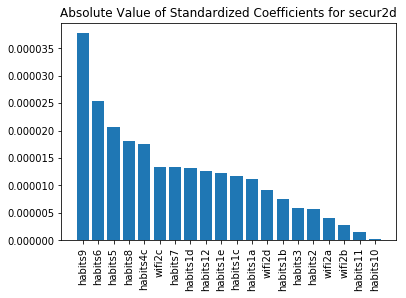

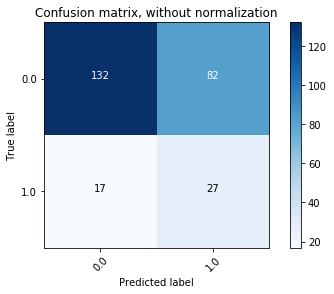


Y = SECUR2E (Someone took over social media account)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0.0: 598, 1.0: 92}
	Classes in ytest: {0.0: 200, 1.0: 31}
	Best Parameters: {'C': 10, 'class_weight': {0: 0.2, 1: 0.8}, 'fit_intercept': False}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.79
	Accuracy on test data:     0.77
	
METRICS FOR TRAINING DATA
	Precision: 0.26
	Recall: 0.33
	F1 Score: 0.29
	Cohen's Kappa: 0.17
	AUC: 0.71


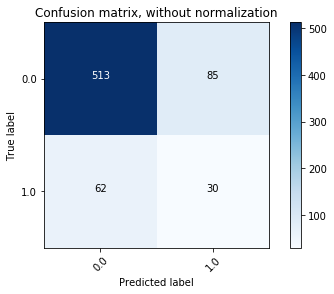

	Accuracy on training data: 0.79
	Accuracy on test data:     0.77
	
METRICS FOR TEST DATA
	Precision: 0.19
	Recall: 0.23
	F1 Score: 0.21
	Cohen's Kappa: 0.08
	AUC: 0.6
	
Standardized coefficients for secur2e

    Coeff_AV  Coefficient  Feature
1   0.385852    -0.385852      age
11  0.307963    -0.307963      inc
5   0.258618     0.258618  marital
0   0.189529     0.189529      sex
8   0.182152    -0.182152    party
3   0.158684     0.158684     hisp
7   0.138974     0.138974  emplnw3
10  0.137766     0.137766     ideo
6   0.114651    -0.114651      par
2   0.063377     0.063377    educ2
4   0.062092    -0.062092  race3m1
12  0.036115     0.036115      usr
9   0.014537    -0.014537  partyln


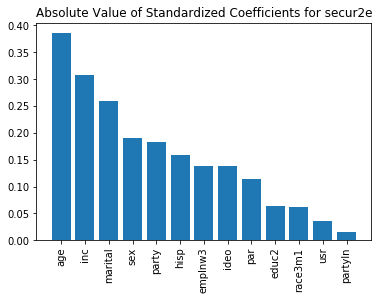

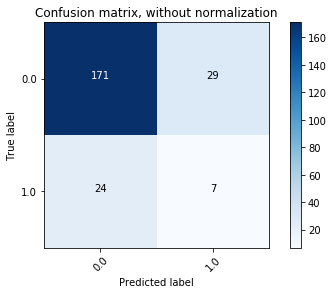


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0.0: 598, 1.0: 92}
	Classes in ytest: {0.0: 200, 1.0: 31}
	Best Parameters: {'C': 0.1, 'class_weight': {0: 0.2, 1: 0.8}, 'fit_intercept': False}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.80
	Accuracy on test data:     0.76
	
METRICS FOR TRAINING DATA
	Precision: 0.31
	Recall: 0.39
	F1 Score: 0.35
	Cohen's Kappa: 0.23
	AUC: 0.73


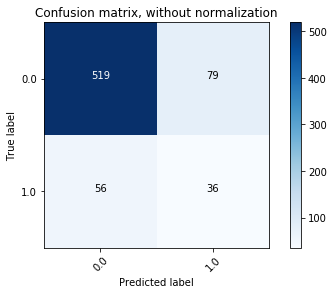

	Accuracy on training data: 0.80
	Accuracy on test data:     0.76
	
METRICS FOR TEST DATA
	Precision: 0.12
	Recall: 0.13
	F1 Score: 0.12
	Cohen's Kappa: -0.02
	AUC: 0.61
	
Standardized coefficients for secur2e

    Coeff_AV  Coefficient   Feature
18  0.313100     0.313100    wifi2c
12  0.287059     0.287059   habits9
10  0.271004     0.271004   habits7
3   0.246314     0.246314  habits1d
19  0.220205    -0.220205    wifi2d
15  0.194362     0.194362  habits12
13  0.178401    -0.178401  habits10
11  0.117501    -0.117501   habits8
9   0.109571     0.109571   habits6
7   0.100688     0.100688  habits4c
6   0.070914    -0.070914   habits3
1   0.063787     0.063787  habits1b
2   0.046124    -0.046124  habits1c
4   0.043483     0.043483  habits1e
8   0.040879    -0.040879   habits5
14  0.040118    -0.040118  habits11
17  0.030943    -0.030943    wifi2b
16  0.027539    -0.027539    wifi2a
5   0.009946    -0.009946   habits2
0   0.000908     0.000908  habits1a


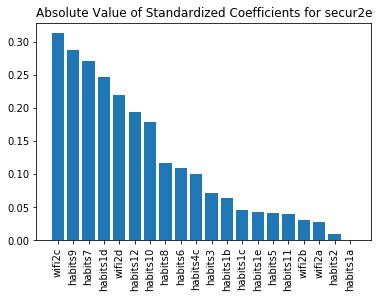

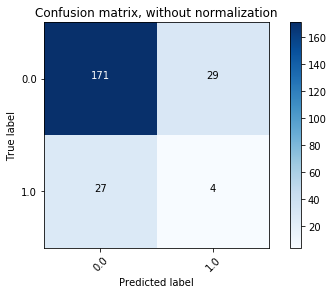


Y = SECUR2F (Someone opened line of credit/applied for loan under name)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0.0: 653, 1.0: 115}
	Classes in ytest: {0.0: 218, 1.0: 38}
	Best Parameters: {'C': 1, 'class_weight': {0: 0.3, 1: 0.7}, 'fit_intercept': False}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.85
	Accuracy on test data:     0.85
	
METRICS FOR TRAINING DATA
	Precision: 0.33
	Recall: 0.02
	F1 Score: 0.03
	Cohen's Kappa: 0.02
	AUC: 0.55


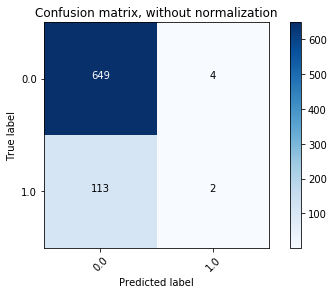

	Accuracy on training data: 0.85
	Accuracy on test data:     0.85
	
METRICS FOR TEST DATA
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: -0.01
	AUC: 0.54
	
Standardized coefficients for secur2f

    Coeff_AV  Coefficient  Feature
3   0.182123     0.182123     hisp
5   0.162322    -0.162322  marital
2   0.153052    -0.153052    educ2
10  0.090967    -0.090967     ideo
6   0.068096    -0.068096      par
4   0.059994     0.059994  race3m1
12  0.059499    -0.059499      usr
7   0.053160    -0.053160  emplnw3
11  0.039815     0.039815      inc
8   0.029152    -0.029152    party
0   0.020312    -0.020312      sex
9   0.011905     0.011905  partyln
1   0.009551     0.009551      age


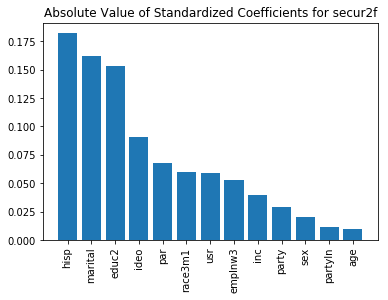

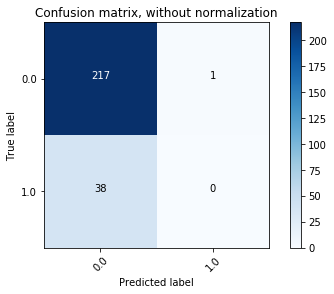


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0.0: 653, 1.0: 115}
	Classes in ytest: {0.0: 218, 1.0: 38}
	Best Parameters: {'C': 1, 'class_weight': {0: 0.2, 1: 0.8}, 'fit_intercept': False}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.71
	Accuracy on test data:     0.70
	
METRICS FOR TRAINING DATA
	Precision: 0.24
	Recall: 0.42
	F1 Score: 0.3
	Cohen's Kappa: 0.14
	AUC: 0.61


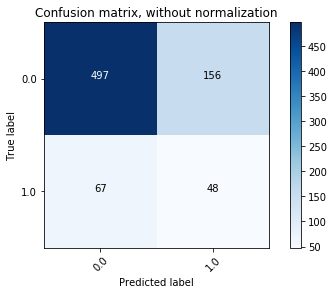

	Accuracy on training data: 0.71
	Accuracy on test data:     0.70
	
METRICS FOR TEST DATA
	Precision: 0.2
	Recall: 0.34
	F1 Score: 0.25
	Cohen's Kappa: 0.08
	AUC: 0.58
	
Standardized coefficients for secur2f

    Coeff_AV  Coefficient   Feature
13  0.200632     0.200632  habits10
15  0.191437     0.191437  habits12
7   0.190385     0.190385  habits4c
14  0.182841    -0.182841  habits11
18  0.175314    -0.175314    wifi2c
11  0.167273    -0.167273   habits8
16  0.148445     0.148445    wifi2a
1   0.133806    -0.133806  habits1b
0   0.124852    -0.124852  habits1a
12  0.116517     0.116517   habits9
10  0.114122     0.114122   habits7
8   0.099061    -0.099061   habits5
3   0.094660     0.094660  habits1d
19  0.084032    -0.084032    wifi2d
5   0.083217     0.083217   habits2
6   0.046743    -0.046743   habits3
2   0.024994    -0.024994  habits1c
9   0.019325    -0.019325   habits6
4   0.011786    -0.011786  habits1e
17  0.008434     0.008434    wifi2b


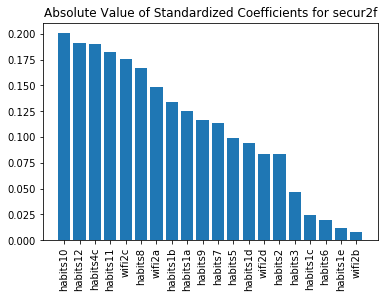

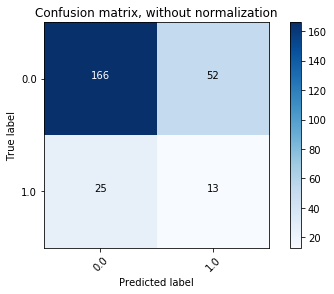


Y = SECUR2G (Someone received tax refund under name)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0.0: 727, 1.0: 43}
	Classes in ytest: {0.0: 243, 1.0: 14}
	Best Parameters: {'C': 1e-06, 'class_weight': {0: 0.1, 1: 0.9}, 'fit_intercept': False}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.94
	Accuracy on test data:     0.95
	
METRICS FOR TRAINING DATA
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0
	AUC: 0.45


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


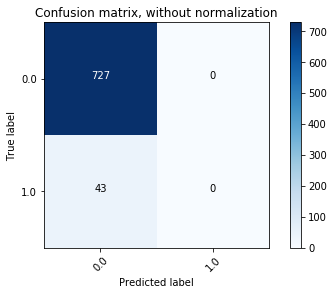

	Accuracy on training data: 0.94
	Accuracy on test data:     0.95
	
METRICS FOR TEST DATA
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0
	AUC: 0.38
	
Standardized coefficients for secur2g

    Coeff_AV  Coefficient  Feature
1   0.014351    -0.014351      age
11  0.005973    -0.005973      inc
2   0.000667    -0.000667    educ2
5   0.000083    -0.000083  marital
10  0.000050    -0.000050     ideo
8   0.000036    -0.000036    party
4   0.000035    -0.000035  race3m1
12  0.000024    -0.000024      usr
7   0.000023    -0.000023  emplnw3
3   0.000008     0.000008     hisp
9   0.000005    -0.000005  partyln
6   0.000003     0.000003      par
0   0.000002     0.000002      sex


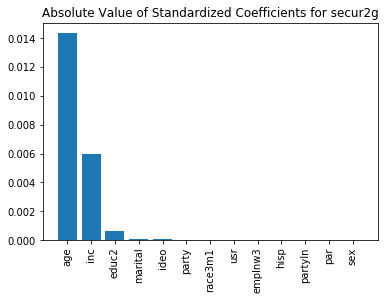

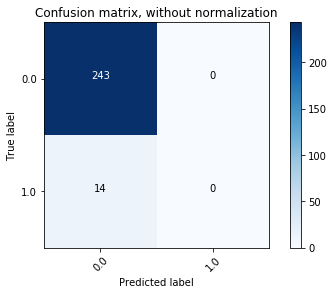


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0.0: 727, 1.0: 43}
	Classes in ytest: {0.0: 243, 1.0: 14}
	Best Parameters: {'C': 10, 'class_weight': {0: 0.2, 1: 0.8}, 'fit_intercept': False}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.94
	Accuracy on test data:     0.93
	
METRICS FOR TRAINING DATA
	Precision: 0.22
	Recall: 0.05
	F1 Score: 0.08
	Cohen's Kappa: 0.06
	AUC: 0.68


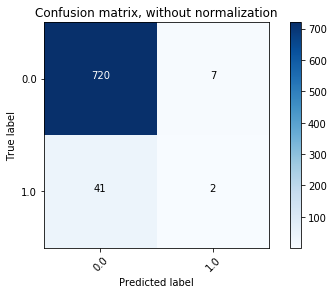

	Accuracy on training data: 0.94
	Accuracy on test data:     0.93
	
METRICS FOR TEST DATA
	Precision: 0.2
	Recall: 0.07
	F1 Score: 0.11
	Cohen's Kappa: 0.08
	AUC: 0.56
	
Standardized coefficients for secur2g

    Coeff_AV  Coefficient   Feature
19  0.362101    -0.362101    wifi2d
5   0.327502    -0.327502   habits2
6   0.298732    -0.298732   habits3
7   0.244335     0.244335  habits4c
2   0.233174     0.233174  habits1c
3   0.227529     0.227529  habits1d
11  0.214163    -0.214163   habits8
12  0.196025    -0.196025   habits9
15  0.193195     0.193195  habits12
1   0.138635     0.138635  habits1b
14  0.135179    -0.135179  habits11
18  0.132705    -0.132705    wifi2c
17  0.103416     0.103416    wifi2b
0   0.085389    -0.085389  habits1a
13  0.076275     0.076275  habits10
9   0.075016    -0.075016   habits6
16  0.069616    -0.069616    wifi2a
4   0.058067     0.058067  habits1e
10  0.041718    -0.041718   habits7
8   0.025255     0.025255   habits5


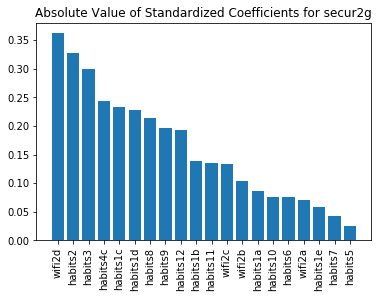

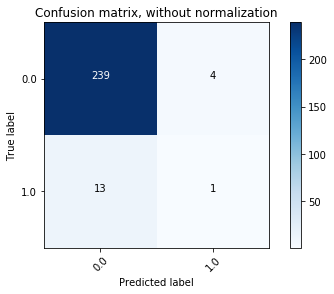

In [27]:
from sklearn.linear_model import LogisticRegression

clf_str = 'logreg'
mod_results = []

# create dictionary of parameters
dict_params = {'C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
               'class_weight': [{0:.1, 1:.9},
                                {0:.2, 1:.8},
                                {0:.3, 1:.7},
                                {0:.4, 1:.6},
                                {0:.5, 1:.5},
                                {0:.6, 1:.4},
                                {0:.7, 1:.3},
                                {0:.8, 1:.2},
                                {0:.9, 1:.1}],
              'fit_intercept': [False]}

# set scoring method for cv_optimize (Cohen's Kappa)
scorer = metrics.make_scorer(metrics.cohen_kappa_score)

""" ======= ITERATE THROUGH SECURITY INCIDENT COLUMNS ======= """
for y_col in sec_cols:

    if y_col != 'ID':
        
        print('\nY = ' + y_col.upper() + ' (' + dict_sec_cols[y_col] + ')')
        
        # remove rows where y_col is don't know/refused (0)
        clf_df = df[df[y_col] != 0]        
        
        # remove ID from dem_cols
        x_cols = dem_cols[1:]
        x_col_set = 'dem'

        """ ======= PERFORM LOGISTIC REGRESSION W/ DEMOGRAPHIC VARIABLES AS FEATURES ======= """

        print('\n\tX = DEMOGRAPHIC VARIABLES') 
        mod_results = do_classify(clf=LogisticRegression(), 
                                  parameters=dict_params, 
                                  df=clf_df,
                                  x_col_set = x_col_set,
                                  feature_names=x_cols,
                                  targetname=y_col,
                                  scorer=scorer,
                                  mod_results=mod_results,
                                  clf_str=clf_str)

        # remove ID from hab_cols
        x_cols = hab_cols[1:]  
        x_col_set = 'hab'
        
        """ ======= PERFORM LOGISTIC REGRESSION W/ SECURITY HABIT VARIABLES AS FEATURES ======= """
        
        print('\n\tX = SECURITY HABIT VARIABLES')
        mod_results = do_classify(clf=LogisticRegression(), 
                                  parameters=dict_params, 
                                  df=clf_df,
                                  x_col_set = x_col_set,
                                  feature_names=x_cols,
                                  targetname=y_col,
                                  scorer=scorer,
                                  mod_results=mod_results,
                                  clf_str=clf_str)
        
        curr_mod_results = pd.DataFrame(mod_results) 
        
# rearrange results column order
curr_mod_results = reorder_cols(curr_mod_results)
curr_mod_results

# add results to final results dataframe
if 'df_mod_results' not in locals(): df_mod_results = create_final_df()
df_mod_results = df_mod_results.append(curr_mod_results)

<div class="alert alert-success">
<h1>KNN</h1>
</div>


Y = SECUR2A (SSN compromised)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0.0: 650, 1.0: 125}
	Classes in ytest: {0.0: 217, 1.0: 42}
	Best Parameters: {'n_neighbors': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.75
	
METRICS FOR TRAINING DATA
	Precision: 1.0
	Recall: 1.0
	F1 Score: 1.0
	Cohen's Kappa: 1.0
	AUC: 1.0


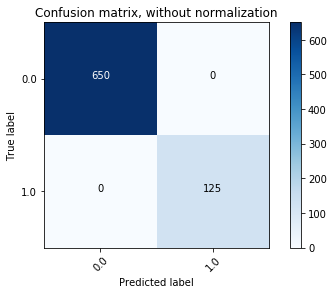

	Accuracy on training data: 1.00
	Accuracy on test data:     0.75
	
METRICS FOR TEST DATA
	Precision: 0.24
	Recall: 0.26
	F1 Score: 0.25
	Cohen's Kappa: 0.1
	AUC: 0.55


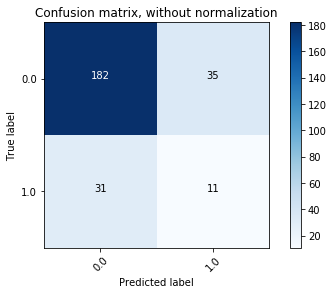


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0.0: 650, 1.0: 125}
	Classes in ytest: {0.0: 217, 1.0: 42}
	Best Parameters: {'n_neighbors': 5}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.84
	Accuracy on test data:     0.82
	
METRICS FOR TRAINING DATA
	Precision: 0.56
	Recall: 0.15
	F1 Score: 0.24
	Cohen's Kappa: 0.18
	AUC: 0.82


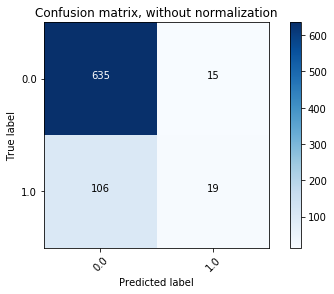

	Accuracy on training data: 0.84
	Accuracy on test data:     0.82
	
METRICS FOR TEST DATA
	Precision: 0.14
	Recall: 0.02
	F1 Score: 0.04
	Cohen's Kappa: -0.01
	AUC: 0.54


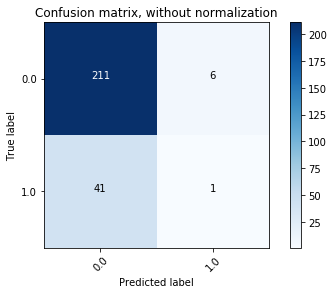


Y = SECUR2B (Other sensitive info compromised)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0.0: 471, 1.0: 301}
	Classes in ytest: {0.0: 157, 1.0: 101}
	Best Parameters: {'n_neighbors': 5}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.73
	Accuracy on test data:     0.64
	
METRICS FOR TRAINING DATA
	Precision: 0.67
	Recall: 0.62
	F1 Score: 0.64
	Cohen's Kappa: 0.43
	AUC: 0.78


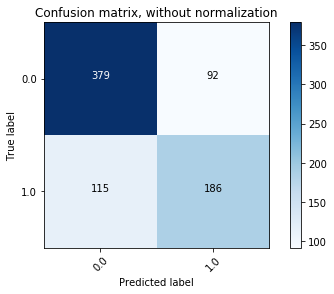

	Accuracy on training data: 0.73
	Accuracy on test data:     0.64
	
METRICS FOR TEST DATA
	Precision: 0.55
	Recall: 0.47
	F1 Score: 0.5
	Cohen's Kappa: 0.22
	AUC: 0.66


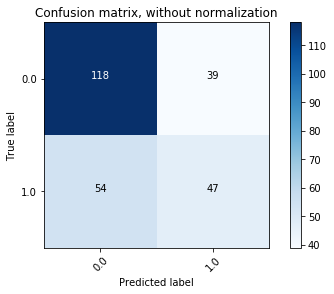


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0.0: 471, 1.0: 301}
	Classes in ytest: {0.0: 157, 1.0: 101}
	Best Parameters: {'n_neighbors': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.92
	Accuracy on test data:     0.57
	
METRICS FOR TRAINING DATA
	Precision: 0.86
	Recall: 0.95
	F1 Score: 0.91
	Cohen's Kappa: 0.84
	AUC: 0.93


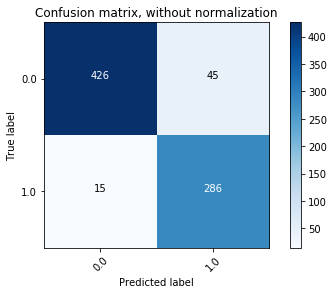

	Accuracy on training data: 0.92
	Accuracy on test data:     0.57
	
METRICS FOR TEST DATA
	Precision: 0.45
	Recall: 0.49
	F1 Score: 0.47
	Cohen's Kappa: 0.11
	AUC: 0.55


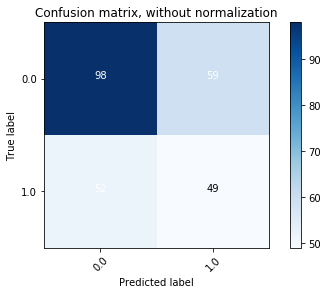


Y = SECUR2C (Fraudulent charges on credit/debit card)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0.0: 421, 1.0: 356}
	Classes in ytest: {0.0: 140, 1.0: 119}
	Best Parameters: {'n_neighbors': 15}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.67
	Accuracy on test data:     0.63
	
METRICS FOR TRAINING DATA
	Precision: 0.67
	Recall: 0.56
	F1 Score: 0.61
	Cohen's Kappa: 0.33
	AUC: 0.72


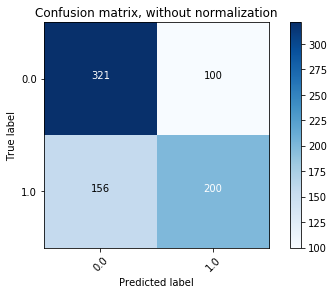

	Accuracy on training data: 0.67
	Accuracy on test data:     0.63
	
METRICS FOR TEST DATA
	Precision: 0.59
	Recall: 0.58
	F1 Score: 0.59
	Cohen's Kappa: 0.24
	AUC: 0.65


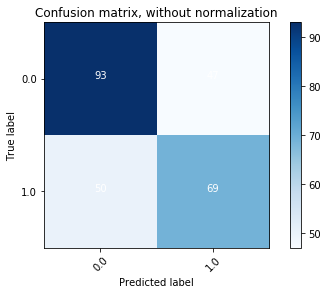


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0.0: 421, 1.0: 356}
	Classes in ytest: {0.0: 140, 1.0: 119}
	Best Parameters: {'n_neighbors': 5}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.73
	Accuracy on test data:     0.54
	
METRICS FOR TRAINING DATA
	Precision: 0.74
	Recall: 0.63
	F1 Score: 0.68
	Cohen's Kappa: 0.45
	AUC: 0.78


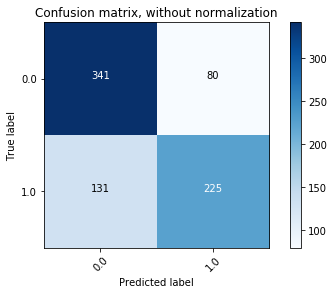

	Accuracy on training data: 0.73
	Accuracy on test data:     0.54
	
METRICS FOR TEST DATA
	Precision: 0.5
	Recall: 0.46
	F1 Score: 0.48
	Cohen's Kappa: 0.07
	AUC: 0.54


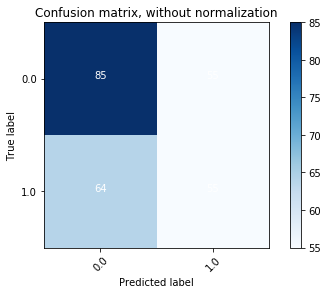


Y = SECUR2D (Someone took over email)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0.0: 641, 1.0: 131}
	Classes in ytest: {0.0: 214, 1.0: 44}
	Best Parameters: {'n_neighbors': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.76
	
METRICS FOR TRAINING DATA
	Precision: 1.0
	Recall: 1.0
	F1 Score: 1.0
	Cohen's Kappa: 1.0
	AUC: 1.0


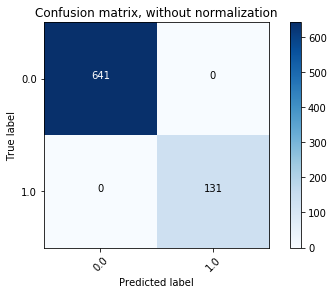

	Accuracy on training data: 1.00
	Accuracy on test data:     0.76
	
METRICS FOR TEST DATA
	Precision: 0.24
	Recall: 0.18
	F1 Score: 0.21
	Cohen's Kappa: 0.07
	AUC: 0.53


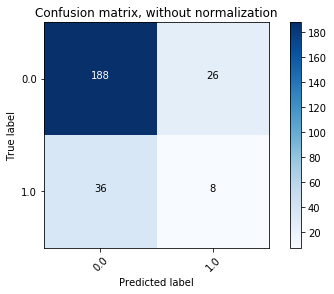


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0.0: 641, 1.0: 131}
	Classes in ytest: {0.0: 214, 1.0: 44}
	Best Parameters: {'n_neighbors': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.99
	Accuracy on test data:     0.71
	
METRICS FOR TRAINING DATA
	Precision: 0.98
	Recall: 0.97
	F1 Score: 0.98
	Cohen's Kappa: 0.97
	AUC: 0.98


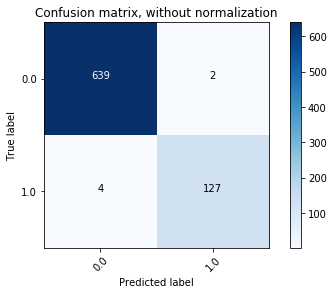

	Accuracy on training data: 0.99
	Accuracy on test data:     0.71
	
METRICS FOR TEST DATA
	Precision: 0.17
	Recall: 0.18
	F1 Score: 0.18
	Cohen's Kappa: -0.0
	AUC: 0.5


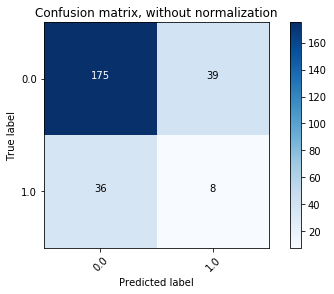


Y = SECUR2E (Someone took over social media account)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0.0: 598, 1.0: 92}
	Classes in ytest: {0.0: 200, 1.0: 31}
	Best Parameters: {'n_neighbors': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.74
	
METRICS FOR TRAINING DATA
	Precision: 1.0
	Recall: 1.0
	F1 Score: 1.0
	Cohen's Kappa: 1.0
	AUC: 1.0


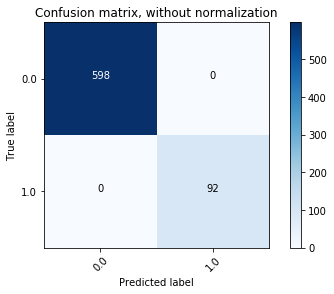

	Accuracy on training data: 1.00
	Accuracy on test data:     0.74
	
METRICS FOR TEST DATA
	Precision: 0.13
	Recall: 0.16
	F1 Score: 0.14
	Cohen's Kappa: -0.01
	AUC: 0.5


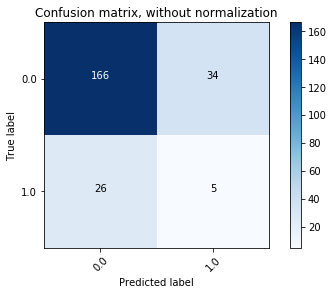


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0.0: 598, 1.0: 92}
	Classes in ytest: {0.0: 200, 1.0: 31}
	Best Parameters: {'n_neighbors': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.99
	Accuracy on test data:     0.83
	
METRICS FOR TRAINING DATA
	Precision: 0.99
	Recall: 0.97
	F1 Score: 0.98
	Cohen's Kappa: 0.97
	AUC: 0.98


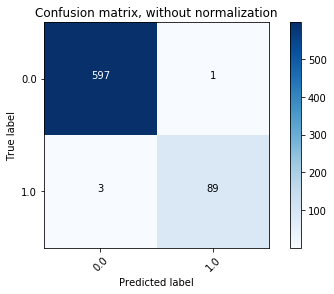

	Accuracy on training data: 0.99
	Accuracy on test data:     0.83
	
METRICS FOR TEST DATA
	Precision: 0.26
	Recall: 0.16
	F1 Score: 0.2
	Cohen's Kappa: 0.11
	AUC: 0.55


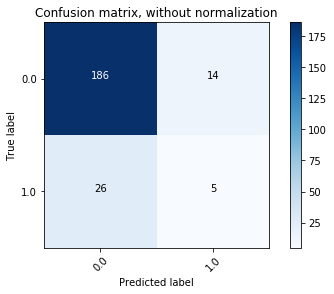


Y = SECUR2F (Someone opened line of credit/applied for loan under name)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0.0: 653, 1.0: 115}
	Classes in ytest: {0.0: 218, 1.0: 38}
	Best Parameters: {'n_neighbors': 15}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.85
	Accuracy on test data:     0.85
	
METRICS FOR TRAINING DATA
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0
	AUC: 0.7


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


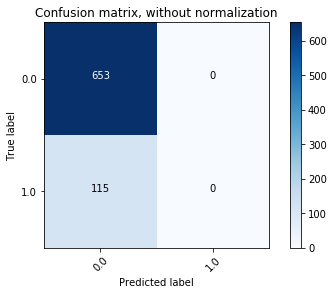

	Accuracy on training data: 0.85
	Accuracy on test data:     0.85
	
METRICS FOR TEST DATA
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0
	AUC: 0.48


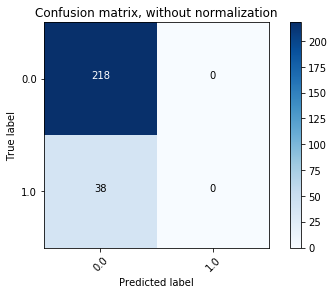


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0.0: 653, 1.0: 115}
	Classes in ytest: {0.0: 218, 1.0: 38}
	Best Parameters: {'n_neighbors': 10}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.85
	Accuracy on test data:     0.85
	
METRICS FOR TRAINING DATA
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0
	AUC: 0.67


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


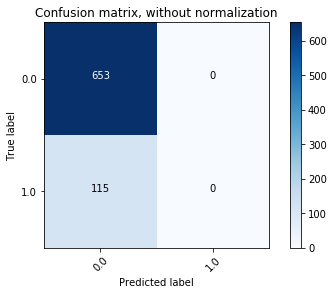

	Accuracy on training data: 0.85
	Accuracy on test data:     0.85
	
METRICS FOR TEST DATA
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0
	AUC: 0.59


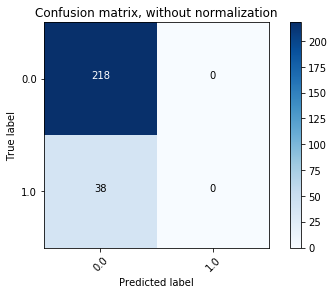


Y = SECUR2G (Someone received tax refund under name)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0.0: 727, 1.0: 43}
	Classes in ytest: {0.0: 243, 1.0: 14}
	Best Parameters: {'n_neighbors': 5}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.94
	Accuracy on test data:     0.95
	
METRICS FOR TRAINING DATA
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0
	AUC: 0.91


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


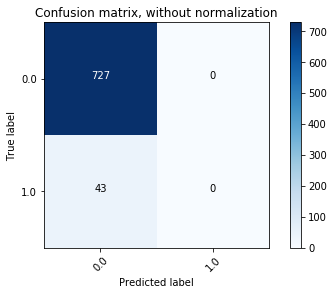

	Accuracy on training data: 0.94
	Accuracy on test data:     0.95
	
METRICS FOR TEST DATA
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0
	AUC: 0.44


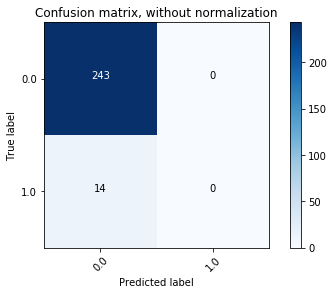


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0.0: 727, 1.0: 43}
	Classes in ytest: {0.0: 243, 1.0: 14}
	Best Parameters: {'n_neighbors': 10}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.94
	Accuracy on test data:     0.95
	
METRICS FOR TRAINING DATA
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0
	AUC: 0.83


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


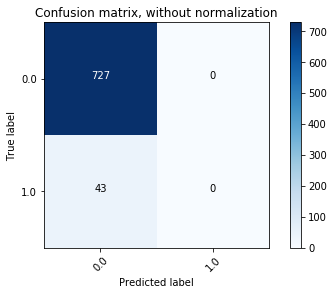

	Accuracy on training data: 0.94
	Accuracy on test data:     0.95
	
METRICS FOR TEST DATA
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0
	AUC: 0.52


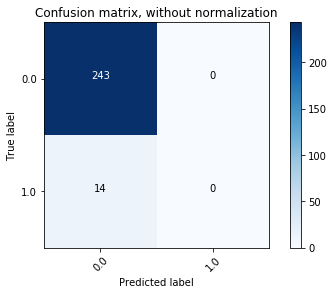

In [28]:
from sklearn.neighbors import KNeighborsClassifier

clf_str = 'knn'
mod_results = []

# create dictionary of parameters
dict_params = {'n_neighbors': [1, 5, 10, 15, 20]}

# set scoring method for cv_optimize (Cohen's Kappa)
scorer = metrics.make_scorer(metrics.cohen_kappa_score)

""" ======= ITERATE THROUGH SECURITY INCIDENT COLUMNS ======= """
for y_col in sec_cols:

    if y_col != 'ID':
        
        print('\nY = ' + y_col.upper() + ' (' + dict_sec_cols[y_col] + ')')
        
        # remove rows where y_col is don't know/refused (0)
        clf_df = df[df[y_col] != 0]     
        
        # remove ID from dem_cols
        x_cols = dem_cols[1:]
        x_col_set = 'dem'

        """ ======= PERFORM KNN W/ DEMOGRAPHIC VARIABLES AS FEATURES ======= """

        print('\n\tX = DEMOGRAPHIC VARIABLES') 
        mod_results = do_classify(clf=KNeighborsClassifier(), 
                                  parameters=dict_params, 
                                  df=clf_df,
                                  x_col_set = x_col_set,
                                  feature_names=x_cols,
                                  targetname=y_col,
                                  scorer=scorer,
                                  mod_results=mod_results,
                                  clf_str=clf_str)

        # remove ID from hab_cols
        x_cols = hab_cols[1:]  
        x_col_set = 'hab'
        
        """ ======= PERFORM KNN W/ SECURITY HABIT VARIABLES AS FEATURES ======= """
        
        print('\n\tX = SECURITY HABIT VARIABLES')
        mod_results = do_classify(clf=KNeighborsClassifier(), 
                                  parameters=dict_params, 
                                  df=clf_df,
                                  x_col_set = x_col_set,
                                  feature_names=x_cols,
                                  targetname=y_col,
                                  scorer=scorer,
                                  mod_results=mod_results,
                                  clf_str=clf_str)
        
        curr_mod_results = pd.DataFrame(mod_results) 
        
# rearrange results column order
curr_mod_results = reorder_cols(curr_mod_results)

# add results to final results dataframe
if 'df_mod_results' not in locals(): df_mod_results = create_final_df()

df_mod_results = df_mod_results.append(curr_mod_results)

<div class="alert alert-success">
<h1>RANDOM FORESTS</h1>
</div>

### Perform Random Forest


Y = SECUR2A (SSN compromised)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0.0: 650, 1.0: 125}
	Classes in ytest: {0.0: 217, 1.0: 42}
	Best Parameters: {'min_samples_split': 9, 'n_estimators': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.83
	Accuracy on test data:     0.76
	
METRICS FOR TRAINING DATA
	Precision: 0.47
	Recall: 0.35
	F1 Score: 0.4
	Cohen's Kappa: 0.31
	AUC: 0.78


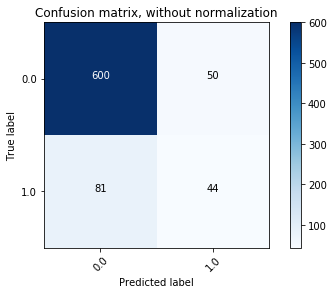

	Accuracy on training data: 0.83
	Accuracy on test data:     0.76
	
METRICS FOR TEST DATA
	Precision: 0.21
	Recall: 0.17
	F1 Score: 0.19
	Cohen's Kappa: 0.05
	AUC: 0.54
	
Feature importances for secur2a

         Importance  Std
age        0.218881  0.0
ideo       0.120883  0.0
educ2      0.108113  0.0
inc        0.094735  0.0
marital    0.094357  0.0
party      0.093981  0.0
sex        0.063042  0.0
partyln    0.054158  0.0
race3m1    0.044808  0.0
hisp       0.035000  0.0
usr        0.031097  0.0
par        0.024092  0.0
emplnw3    0.016852  0.0


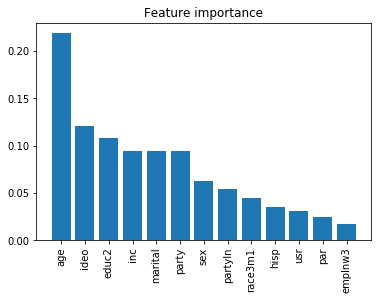

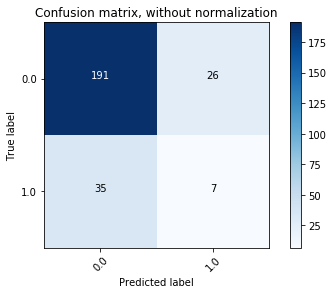


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0.0: 650, 1.0: 125}
	Classes in ytest: {0.0: 217, 1.0: 42}
	Best Parameters: {'min_samples_split': 3, 'n_estimators': 25}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.97
	Accuracy on test data:     0.83
	
METRICS FOR TRAINING DATA
	Precision: 0.98
	Recall: 0.8
	F1 Score: 0.88
	Cohen's Kappa: 0.86
	AUC: 0.98


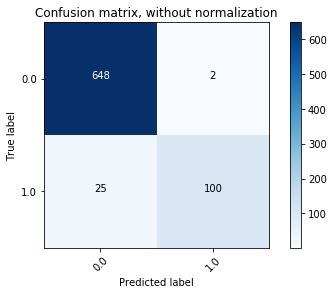

	Accuracy on training data: 0.97
	Accuracy on test data:     0.83
	
METRICS FOR TEST DATA
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: -0.01
	AUC: 0.53
	
Feature importances for secur2a

          Importance           Std
habits9     0.110328  0.000000e+00
habits2     0.098572  2.775558e-17
habits10    0.097865  0.000000e+00
habits11    0.080347  1.387779e-17
habits3     0.070168  2.775558e-17
habits6     0.050794  2.081668e-17
habits5     0.049296  1.387779e-17
habits12    0.048421  0.000000e+00
habits1b    0.047789  1.387779e-17
habits8     0.043706  0.000000e+00
habits7     0.042215  1.387779e-17
habits1a    0.040601  6.938894e-18
habits4c    0.036784  1.387779e-17
wifi2d      0.034171  0.000000e+00
habits1c    0.032532  0.000000e+00
habits1d    0.028500  6.938894e-18
habits1e    0.027481  1.040834e-17
wifi2c      0.026494  1.040834e-17
wifi2b      0.018071  6.938894e-18
wifi2a      0.015866  6.938894e-18


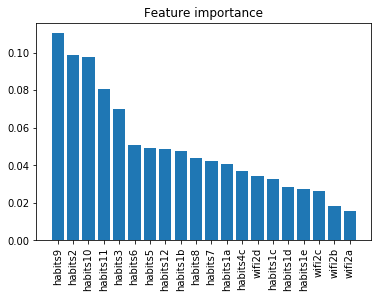

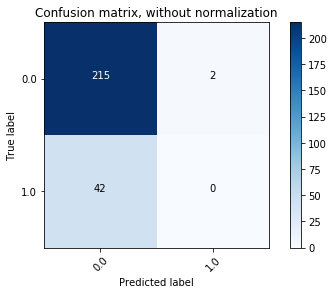


Y = SECUR2B (Other sensitive info compromised)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0.0: 471, 1.0: 301}
	Classes in ytest: {0.0: 157, 1.0: 101}
	Best Parameters: {'min_samples_split': 5, 'n_estimators': 30}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.97
	Accuracy on test data:     0.61
	
METRICS FOR TRAINING DATA
	Precision: 0.98
	Recall: 0.93
	F1 Score: 0.96
	Cohen's Kappa: 0.93
	AUC: 1.0


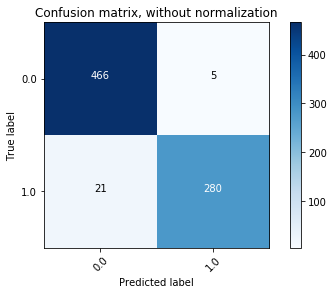

	Accuracy on training data: 0.97
	Accuracy on test data:     0.61
	
METRICS FOR TEST DATA
	Precision: 0.51
	Recall: 0.3
	F1 Score: 0.37
	Cohen's Kappa: 0.12
	AUC: 0.63
	
Feature importances for secur2b

         Importance           Std
age        0.210669  5.551115e-17
inc        0.136667  0.000000e+00
educ2      0.104306  0.000000e+00
ideo       0.098835  1.387779e-17
marital    0.086303  4.163336e-17
party      0.070823  0.000000e+00
usr        0.063992  2.775558e-17
race3m1    0.052207  1.387779e-17
emplnw3    0.050536  6.938894e-18
partyln    0.044347  6.938894e-18
sex        0.036532  1.387779e-17
par        0.027632  6.938894e-18
hisp       0.017152  0.000000e+00


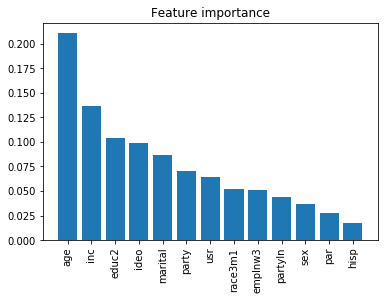

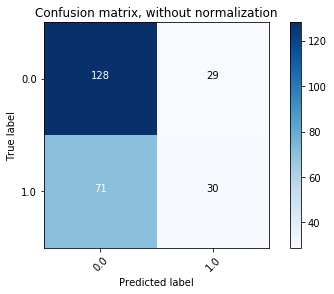


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0.0: 471, 1.0: 301}
	Classes in ytest: {0.0: 157, 1.0: 101}
	Best Parameters: {'min_samples_split': 7, 'n_estimators': 15}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.86
	Accuracy on test data:     0.56
	
METRICS FOR TRAINING DATA
	Precision: 0.9
	Recall: 0.71
	F1 Score: 0.79
	Cohen's Kappa: 0.69
	AUC: 0.91


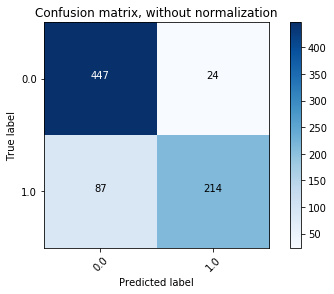

	Accuracy on training data: 0.86
	Accuracy on test data:     0.56
	
METRICS FOR TEST DATA
	Precision: 0.4
	Recall: 0.25
	F1 Score: 0.3
	Cohen's Kappa: 0.01
	AUC: 0.53
	
Feature importances for secur2b

          Importance           Std
habits2     0.086036  0.000000e+00
habits10    0.082953  0.000000e+00
habits4c    0.075986  1.387779e-17
habits9     0.075591  1.387779e-17
habits6     0.071800  1.387779e-17
habits11    0.071627  0.000000e+00
habits3     0.063361  2.775558e-17
habits7     0.048413  6.938894e-18
habits12    0.045123  6.938894e-18
habits1b    0.042548  0.000000e+00
habits8     0.040716  0.000000e+00
wifi2c      0.039459  0.000000e+00
habits1d    0.038507  6.938894e-18
wifi2a      0.037002  6.938894e-18
habits5     0.034373  6.938894e-18
wifi2d      0.033973  6.938894e-18
habits1e    0.031068  1.040834e-17
habits1a    0.030180  6.938894e-18
habits1c    0.028131  6.938894e-18
wifi2b      0.023152  0.000000e+00


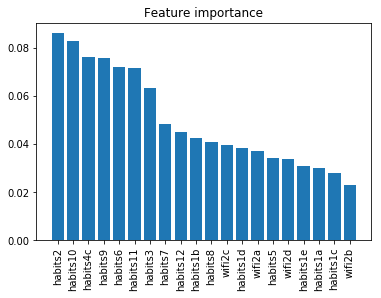

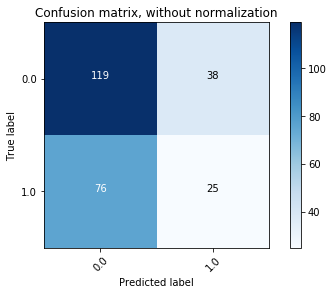


Y = SECUR2C (Fraudulent charges on credit/debit card)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0.0: 421, 1.0: 356}
	Classes in ytest: {0.0: 140, 1.0: 119}
	Best Parameters: {'min_samples_split': 20, 'n_estimators': 25}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.79
	Accuracy on test data:     0.64
	
METRICS FOR TRAINING DATA
	Precision: 0.8
	Recall: 0.72
	F1 Score: 0.76
	Cohen's Kappa: 0.57
	AUC: 0.89


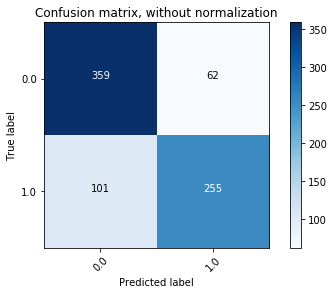

	Accuracy on training data: 0.79
	Accuracy on test data:     0.64
	
METRICS FOR TEST DATA
	Precision: 0.62
	Recall: 0.55
	F1 Score: 0.58
	Cohen's Kappa: 0.27
	AUC: 0.66
	
Feature importances for secur2c

         Importance           Std
inc        0.212544  5.551115e-17
age        0.171242  5.551115e-17
educ2      0.126295  8.326673e-17
marital    0.099189  2.775558e-17
ideo       0.070962  4.163336e-17
emplnw3    0.066125  0.000000e+00
party      0.056396  1.387779e-17
usr        0.049587  6.938894e-18
race3m1    0.049122  1.387779e-17
partyln    0.037687  2.081668e-17
sex        0.028229  1.040834e-17
par        0.016336  3.469447e-18
hisp       0.016286  6.938894e-18


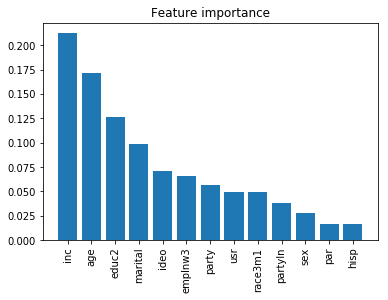

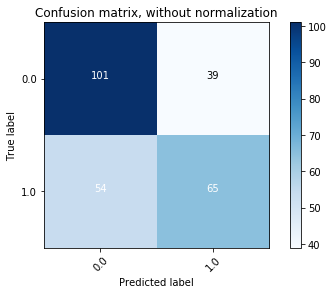


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0.0: 421, 1.0: 356}
	Classes in ytest: {0.0: 140, 1.0: 119}
	Best Parameters: {'min_samples_split': 20, 'n_estimators': 15}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.76
	Accuracy on test data:     0.59
	
METRICS FOR TRAINING DATA
	Precision: 0.74
	Recall: 0.72
	F1 Score: 0.73
	Cohen's Kappa: 0.51
	AUC: 0.83


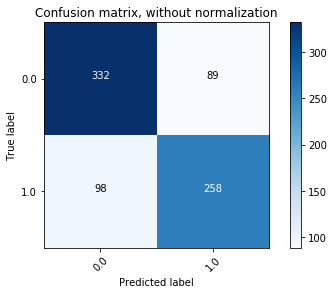

	Accuracy on training data: 0.76
	Accuracy on test data:     0.59
	
METRICS FOR TEST DATA
	Precision: 0.55
	Recall: 0.6
	F1 Score: 0.57
	Cohen's Kappa: 0.17
	AUC: 0.62
	
Feature importances for secur2c

          Importance           Std
habits6     0.103951  4.163336e-17
habits10    0.089595  1.387779e-17
habits9     0.078351  0.000000e+00
habits5     0.071744  2.775558e-17
habits4c    0.069308  1.387779e-17
habits2     0.062292  1.387779e-17
habits11    0.058017  2.081668e-17
habits3     0.053743  1.387779e-17
wifi2d      0.053573  6.938894e-18
habits8     0.052905  6.938894e-18
habits12    0.050749  0.000000e+00
habits1b    0.041011  0.000000e+00
wifi2c      0.039099  0.000000e+00
habits1a    0.033522  6.938894e-18
wifi2a      0.029529  1.040834e-17
habits7     0.029516  6.938894e-18
habits1d    0.027961  6.938894e-18
habits1c    0.024976  0.000000e+00
habits1e    0.021179  0.000000e+00
wifi2b      0.008980  0.000000e+00


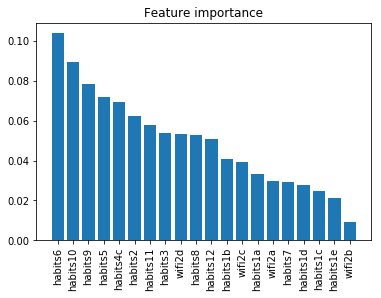

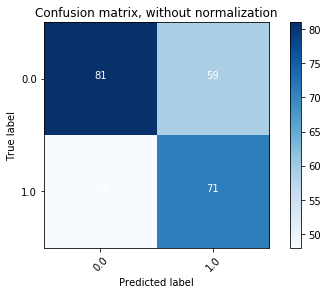


Y = SECUR2D (Someone took over email)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0.0: 641, 1.0: 131}
	Classes in ytest: {0.0: 214, 1.0: 44}
	Best Parameters: {'min_samples_split': 5, 'n_estimators': 5}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.91
	Accuracy on test data:     0.79
	
METRICS FOR TRAINING DATA
	Precision: 0.9
	Recall: 0.5
	F1 Score: 0.65
	Cohen's Kappa: 0.6
	AUC: 0.96


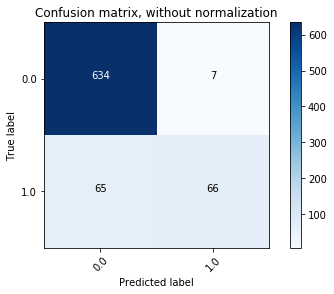

	Accuracy on training data: 0.91
	Accuracy on test data:     0.79
	
METRICS FOR TEST DATA
	Precision: 0.15
	Recall: 0.05
	F1 Score: 0.07
	Cohen's Kappa: -0.01
	AUC: 0.58
	
Feature importances for secur2d

         Importance  Std
age        0.244169  0.0
inc        0.141269  0.0
ideo       0.106139  0.0
educ2      0.086836  0.0
party      0.069077  0.0
marital    0.064118  0.0
emplnw3    0.056164  0.0
partyln    0.054031  0.0
usr        0.046308  0.0
par        0.037809  0.0
race3m1    0.032672  0.0
hisp       0.032647  0.0
sex        0.028760  0.0


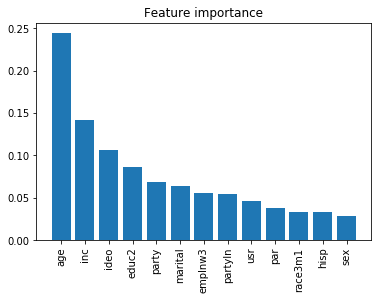

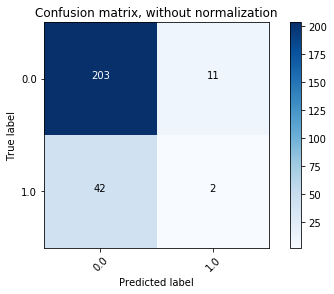


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0.0: 641, 1.0: 131}
	Classes in ytest: {0.0: 214, 1.0: 44}
	Best Parameters: {'min_samples_split': 10, 'n_estimators': 5}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.87
	Accuracy on test data:     0.79
	
METRICS FOR TRAINING DATA
	Precision: 0.82
	Recall: 0.32
	F1 Score: 0.46
	Cohen's Kappa: 0.4
	AUC: 0.91


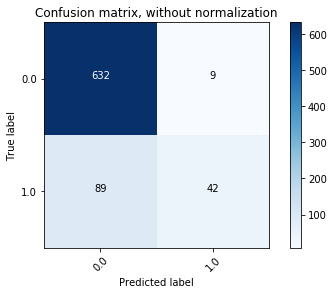

	Accuracy on training data: 0.87
	Accuracy on test data:     0.79
	
METRICS FOR TEST DATA
	Precision: 0.09
	Recall: 0.02
	F1 Score: 0.04
	Cohen's Kappa: -0.03
	AUC: 0.59
	
Feature importances for secur2d

          Importance  Std
habits11    0.111542  0.0
habits10    0.104502  0.0
habits9     0.097465  0.0
habits12    0.068833  0.0
wifi2a      0.064231  0.0
habits2     0.061327  0.0
wifi2c      0.055880  0.0
habits1b    0.051213  0.0
habits3     0.049274  0.0
habits1c    0.047753  0.0
habits7     0.045741  0.0
habits4c    0.038976  0.0
habits6     0.035695  0.0
habits5     0.034756  0.0
wifi2d      0.029873  0.0
habits1e    0.026846  0.0
habits1a    0.023293  0.0
wifi2b      0.022108  0.0
habits1d    0.016649  0.0
habits8     0.014044  0.0


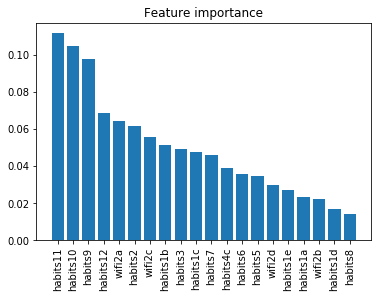

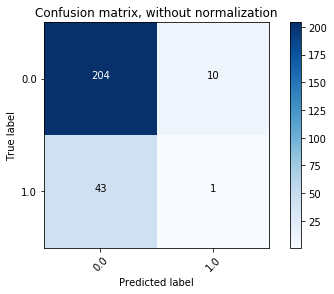


Y = SECUR2E (Someone took over social media account)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0.0: 598, 1.0: 92}
	Classes in ytest: {0.0: 200, 1.0: 31}
	Best Parameters: {'min_samples_split': 7, 'n_estimators': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.89
	Accuracy on test data:     0.80
	
METRICS FOR TRAINING DATA
	Precision: 0.6
	Recall: 0.47
	F1 Score: 0.52
	Cohen's Kappa: 0.46
	AUC: 0.81


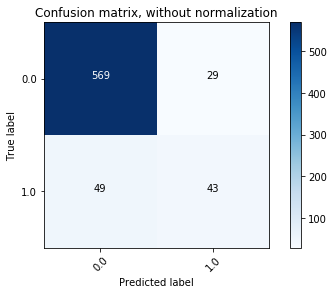

	Accuracy on training data: 0.89
	Accuracy on test data:     0.80
	
METRICS FOR TEST DATA
	Precision: 0.22
	Recall: 0.19
	F1 Score: 0.21
	Cohen's Kappa: 0.09
	AUC: 0.59
	
Feature importances for secur2e

         Importance  Std
age        0.405100  0.0
ideo       0.104755  0.0
race3m1    0.080916  0.0
marital    0.079924  0.0
emplnw3    0.064542  0.0
usr        0.058883  0.0
par        0.053689  0.0
inc        0.050485  0.0
educ2      0.043783  0.0
partyln    0.033820  0.0
hisp       0.016904  0.0
sex        0.005704  0.0
party      0.001495  0.0


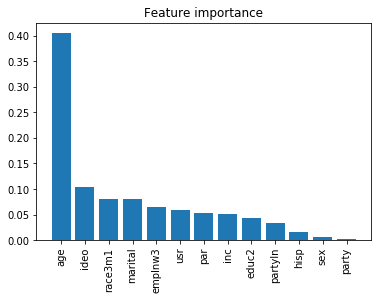

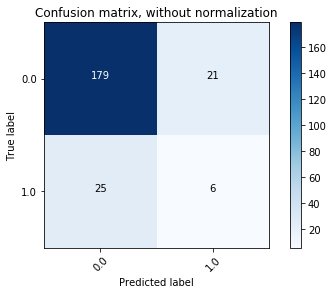


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0.0: 598, 1.0: 92}
	Classes in ytest: {0.0: 200, 1.0: 31}
	Best Parameters: {'min_samples_split': 3, 'n_estimators': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.89
	Accuracy on test data:     0.80
	
METRICS FOR TRAINING DATA
	Precision: 0.65
	Recall: 0.43
	F1 Score: 0.52
	Cohen's Kappa: 0.46
	AUC: 0.81


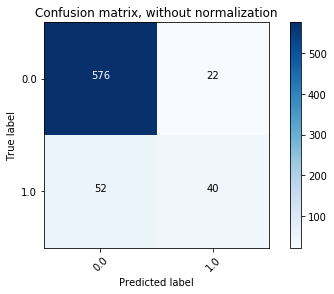

	Accuracy on training data: 0.89
	Accuracy on test data:     0.80
	
METRICS FOR TEST DATA
	Precision: 0.22
	Recall: 0.19
	F1 Score: 0.21
	Cohen's Kappa: 0.09
	AUC: 0.55
	
Feature importances for secur2e

          Importance  Std
habits10    0.134360  0.0
habits9     0.133497  0.0
habits11    0.112789  0.0
habits1a    0.084567  0.0
habits3     0.064628  0.0
habits12    0.060634  0.0
habits4c    0.060460  0.0
habits6     0.040887  0.0
habits8     0.040240  0.0
habits2     0.039883  0.0
wifi2b      0.035583  0.0
wifi2d      0.031573  0.0
habits1c    0.031085  0.0
habits7     0.030491  0.0
habits1d    0.028674  0.0
habits1b    0.023287  0.0
habits5     0.015760  0.0
habits1e    0.014926  0.0
wifi2c      0.013332  0.0
wifi2a      0.003343  0.0


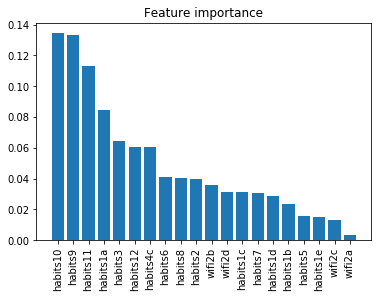

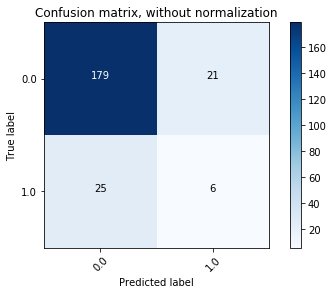


Y = SECUR2F (Someone opened line of credit/applied for loan under name)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0.0: 653, 1.0: 115}
	Classes in ytest: {0.0: 218, 1.0: 38}
	Best Parameters: {'min_samples_split': 8, 'n_estimators': 5}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.89
	Accuracy on test data:     0.84
	
METRICS FOR TRAINING DATA
	Precision: 0.97
	Recall: 0.25
	F1 Score: 0.4
	Cohen's Kappa: 0.36
	AUC: 0.95


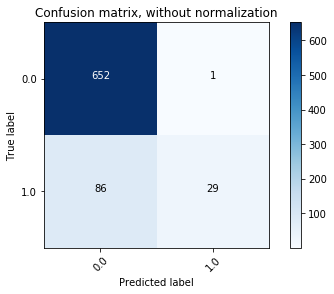

	Accuracy on training data: 0.89
	Accuracy on test data:     0.84
	
METRICS FOR TEST DATA
	Precision: 0.25
	Recall: 0.05
	F1 Score: 0.09
	Cohen's Kappa: 0.04
	AUC: 0.51
	
Feature importances for secur2f

         Importance  Std
age        0.196447  0.0
educ2      0.146125  0.0
marital    0.106946  0.0
inc        0.091462  0.0
ideo       0.085128  0.0
race3m1    0.077582  0.0
party      0.072313  0.0
partyln    0.058529  0.0
usr        0.040556  0.0
hisp       0.040400  0.0
par        0.031170  0.0
emplnw3    0.028198  0.0
sex        0.025142  0.0


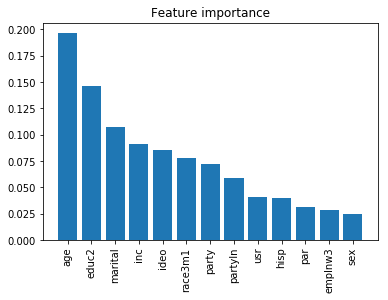

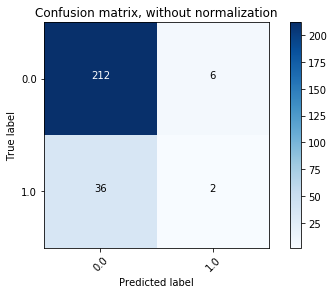


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0.0: 653, 1.0: 115}
	Classes in ytest: {0.0: 218, 1.0: 38}
	Best Parameters: {'min_samples_split': 20, 'n_estimators': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.83
	Accuracy on test data:     0.80
	
METRICS FOR TRAINING DATA
	Precision: 0.34
	Recall: 0.16
	F1 Score: 0.21
	Cohen's Kappa: 0.13
	AUC: 0.71


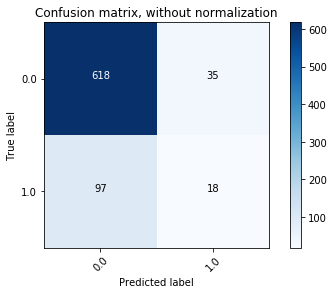

	Accuracy on training data: 0.83
	Accuracy on test data:     0.80
	
METRICS FOR TEST DATA
	Precision: 0.07
	Recall: 0.03
	F1 Score: 0.04
	Cohen's Kappa: -0.05
	AUC: 0.52
	
Feature importances for secur2f

          Importance  Std
habits10    0.142524  0.0
habits1a    0.114746  0.0
habits2     0.100653  0.0
habits9     0.091454  0.0
habits8     0.085482  0.0
habits6     0.071824  0.0
habits11    0.071385  0.0
habits1b    0.070004  0.0
habits7     0.063481  0.0
habits12    0.063223  0.0
habits5     0.058514  0.0
habits1e    0.045722  0.0
wifi2d      0.009301  0.0
wifi2b      0.007534  0.0
habits3     0.004153  0.0
habits4c    0.000000  0.0
habits1d    0.000000  0.0
habits1c    0.000000  0.0
wifi2a      0.000000  0.0
wifi2c      0.000000  0.0


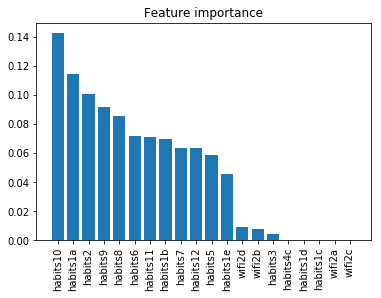

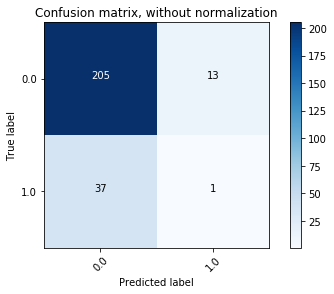


Y = SECUR2G (Someone received tax refund under name)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0.0: 727, 1.0: 43}
	Classes in ytest: {0.0: 243, 1.0: 14}
	Best Parameters: {'min_samples_split': 4, 'n_estimators': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.95
	Accuracy on test data:     0.91
	
METRICS FOR TRAINING DATA
	Precision: 0.53
	Recall: 0.4
	F1 Score: 0.45
	Cohen's Kappa: 0.43
	AUC: 0.81


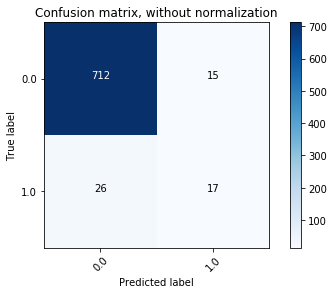

	Accuracy on training data: 0.95
	Accuracy on test data:     0.91
	
METRICS FOR TEST DATA
	Precision: 0.08
	Recall: 0.07
	F1 Score: 0.08
	Cohen's Kappa: 0.03
	AUC: 0.49
	
Feature importances for secur2g

         Importance  Std
age        0.250687  0.0
inc        0.122168  0.0
party      0.109919  0.0
ideo       0.102996  0.0
marital    0.091566  0.0
educ2      0.073832  0.0
race3m1    0.067795  0.0
emplnw3    0.058969  0.0
sex        0.034260  0.0
hisp       0.030687  0.0
par        0.021933  0.0
partyln    0.021590  0.0
usr        0.013598  0.0


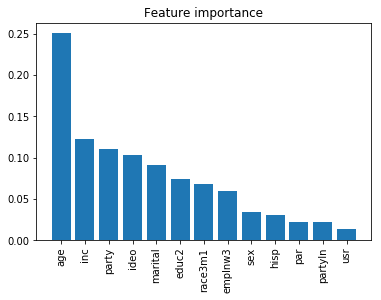

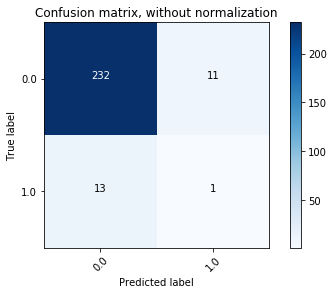


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0.0: 727, 1.0: 43}
	Classes in ytest: {0.0: 243, 1.0: 14}
	Best Parameters: {'min_samples_split': 5, 'n_estimators': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.94
	Accuracy on test data:     0.91
	
METRICS FOR TRAINING DATA
	Precision: 0.44
	Recall: 0.19
	F1 Score: 0.26
	Cohen's Kappa: 0.24
	AUC: 0.82


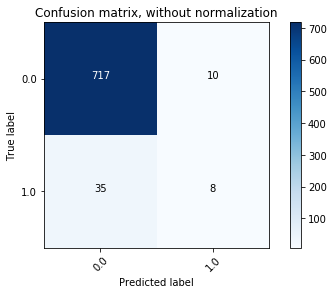

	Accuracy on training data: 0.94
	Accuracy on test data:     0.91
	
METRICS FOR TEST DATA
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: -0.04
	AUC: 0.51
	
Feature importances for secur2g

          Importance  Std
habits1b    0.163711  0.0
habits1a    0.141950  0.0
habits6     0.113555  0.0
habits9     0.109255  0.0
habits3     0.094115  0.0
habits2     0.085733  0.0
habits11    0.040873  0.0
wifi2c      0.039407  0.0
habits1d    0.039074  0.0
wifi2d      0.031343  0.0
habits10    0.030075  0.0
habits5     0.029006  0.0
habits1e    0.024380  0.0
wifi2a      0.014632  0.0
habits7     0.012981  0.0
habits8     0.010205  0.0
habits1c    0.007306  0.0
habits4c    0.006382  0.0
wifi2b      0.006017  0.0
habits12    0.000000  0.0


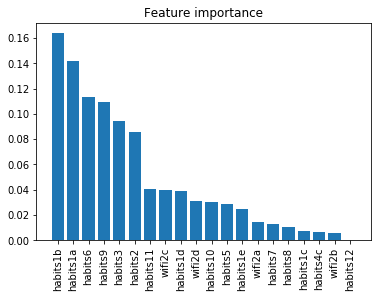

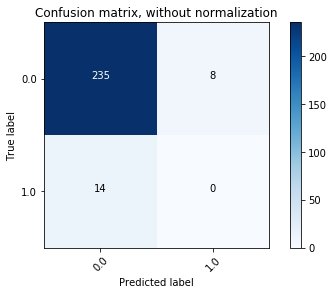

In [29]:
from sklearn.ensemble import RandomForestClassifier

clf_str = 'RF'
mod_results = []

dict_params = {'n_estimators': [1, 5, 10, 15, 20, 25, 30],
               'min_samples_split': [3, 4, 5, 6, 7, 8, 9, 10, 20]}

# set scoring method for cv_optimize (Cohen's Kappa)
scorer = metrics.make_scorer(metrics.cohen_kappa_score)

""" ======= ITERATE THROUGH SECURITY INCIDENT COLUMNS ======= """
for y_col in sec_cols:

    if y_col != 'ID':
        
        print('\nY = ' + y_col.upper() + ' (' + dict_sec_cols[y_col] + ')')
        
        # remove rows where y_col is don't know/refused (0)
        clf_df = df[df[y_col] != 0]        
        
        # remove ID from dem_cols
        x_cols = dem_cols[1:]
        x_col_set = 'dem'

        """ ======= PERFORM RANDOM FOREST W/ DEMOGRAPHIC VARIABLES AS FEATURES ======= """

        print('\n\tX = DEMOGRAPHIC VARIABLES') 
        mod_results = do_classify(clf=RandomForestClassifier(), 
                                  parameters=dict_params, 
                                  df=clf_df,
                                  x_col_set = x_col_set,
                                  feature_names=x_cols,
                                  targetname=y_col,
                                  scorer=scorer,
                                  mod_results=mod_results,
                                  clf_str=clf_str)

        # remove ID from hab_cols
        x_cols = hab_cols[1:]  
        x_col_set = 'hab'
        
        """ ======= PERFORM RANDOM FOREST W/ SECURITY HABITS VARIABLES AS FEATURES ======= """
        
        print('\n\tX = SECURITY HABIT VARIABLES')
        mod_results = do_classify(clf=RandomForestClassifier(), 
                                  parameters=dict_params, 
                                  df=clf_df,
                                  x_col_set = x_col_set,
                                  feature_names=x_cols,
                                  targetname=y_col,
                                  scorer=scorer,
                                  mod_results=mod_results,
                                  clf_str=clf_str)
        
        curr_mod_results = pd.DataFrame(mod_results) 
        
# rearrange results column order
curr_mod_results = reorder_cols(curr_mod_results)

# add results to final results dataframe
if 'df_mod_results' not in locals(): df_mod_results = create_final_df()

df_mod_results = df_mod_results.append(curr_mod_results)

<div class="alert alert-success">
<h1>SVC</h1>
</div>

SVC models represent data as points in space, mapped so that the data of the different categories are divided by a gap that's as wide as possible 
* C: parameter for slack variables; trades off misclassification of training examples against simplicity of decision surface (low values = allows more slack, ensures hyperplane won't change dramatically for outliers)
* Gamma: how far the influence of a single training sample reaches (low values = 'far')


Y = SECUR2A (SSN compromised)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0.0: 650, 1.0: 125}
	Classes in ytest: {0.0: 217, 1.0: 42}
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.84
	
METRICS FOR TRAINING DATA
	Precision: 1.0
	Recall: 1.0
	F1 Score: 1.0
	Cohen's Kappa: 1.0


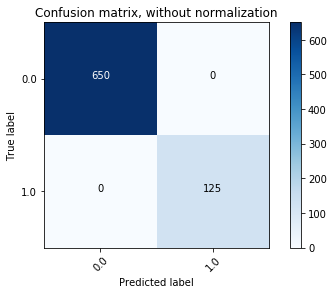

	Accuracy on training data: 1.00
	Accuracy on test data:     0.84
	
METRICS FOR TEST DATA
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


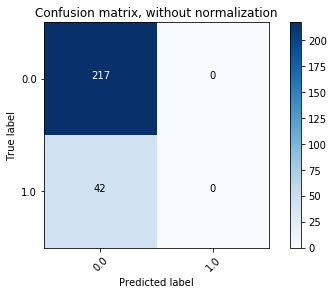


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0.0: 650, 1.0: 125}
	Classes in ytest: {0.0: 217, 1.0: 42}
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.98
	Accuracy on test data:     0.83
	
METRICS FOR TRAINING DATA
	Precision: 1.0
	Recall: 0.86
	F1 Score: 0.93
	Cohen's Kappa: 0.91


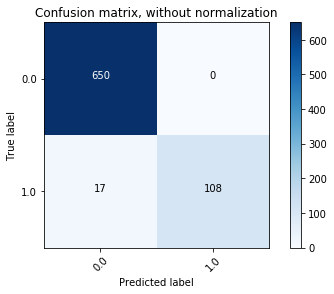

	Accuracy on training data: 0.98
	Accuracy on test data:     0.83
	
METRICS FOR TEST DATA
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: -0.01


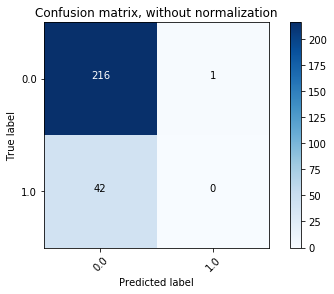


Y = SECUR2B (Other sensitive info compromised)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0.0: 471, 1.0: 301}
	Classes in ytest: {0.0: 157, 1.0: 101}
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.61
	
METRICS FOR TRAINING DATA
	Precision: 1.0
	Recall: 0.99
	F1 Score: 1.0
	Cohen's Kappa: 0.99


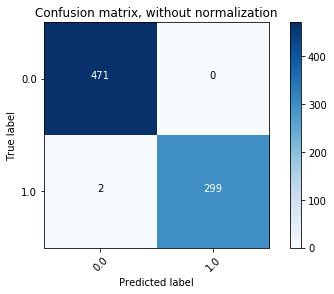

	Accuracy on training data: 1.00
	Accuracy on test data:     0.61
	
METRICS FOR TEST DATA
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


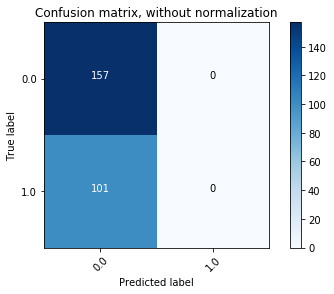


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0.0: 471, 1.0: 301}
	Classes in ytest: {0.0: 157, 1.0: 101}
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 10}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.96
	Accuracy on test data:     0.60
	
METRICS FOR TRAINING DATA
	Precision: 1.0
	Recall: 0.9
	F1 Score: 0.95
	Cohen's Kappa: 0.91


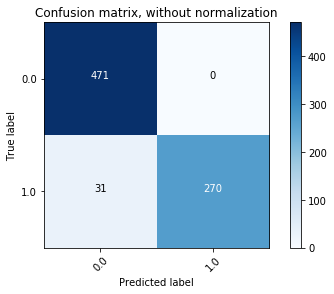

	Accuracy on training data: 0.96
	Accuracy on test data:     0.60
	
METRICS FOR TEST DATA
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: -0.01


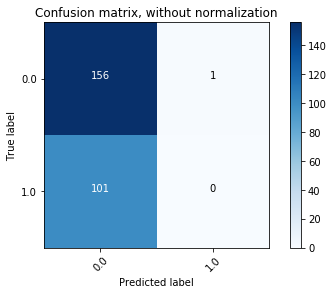


Y = SECUR2C (Fraudulent charges on credit/debit card)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0.0: 421, 1.0: 356}
	Classes in ytest: {0.0: 140, 1.0: 119}
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.54
	
METRICS FOR TRAINING DATA
	Precision: 1.0
	Recall: 1.0
	F1 Score: 1.0
	Cohen's Kappa: 1.0


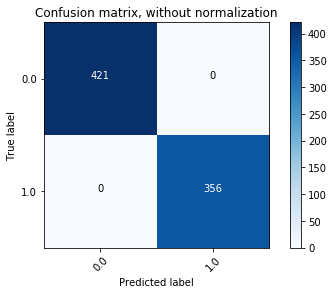

	Accuracy on training data: 1.00
	Accuracy on test data:     0.54
	
METRICS FOR TEST DATA
	Precision: 0.5
	Recall: 0.01
	F1 Score: 0.02
	Cohen's Kappa: 0.0


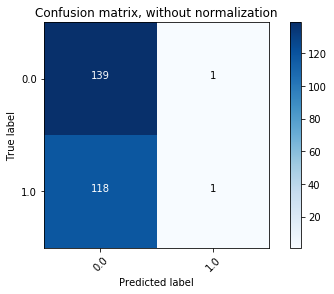


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0.0: 421, 1.0: 356}
	Classes in ytest: {0.0: 140, 1.0: 119}
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.96
	Accuracy on test data:     0.56
	
METRICS FOR TRAINING DATA
	Precision: 1.0
	Recall: 0.91
	F1 Score: 0.95
	Cohen's Kappa: 0.92


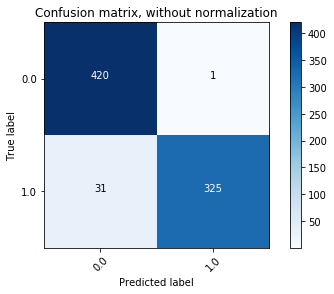

	Accuracy on training data: 0.96
	Accuracy on test data:     0.56
	
METRICS FOR TEST DATA
	Precision: 0.52
	Recall: 0.75
	F1 Score: 0.61
	Cohen's Kappa: 0.15


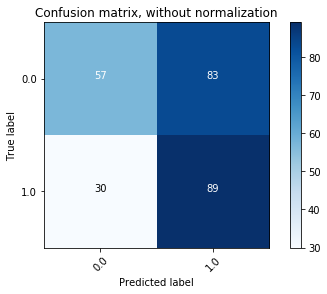


Y = SECUR2D (Someone took over email)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0.0: 641, 1.0: 131}
	Classes in ytest: {0.0: 214, 1.0: 44}
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.83
	
METRICS FOR TRAINING DATA
	Precision: 1.0
	Recall: 1.0
	F1 Score: 1.0
	Cohen's Kappa: 1.0


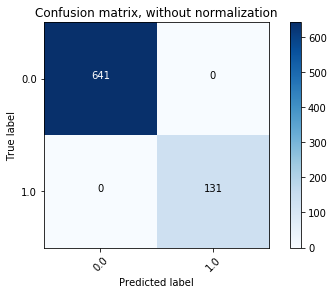

	Accuracy on training data: 1.00
	Accuracy on test data:     0.83
	
METRICS FOR TEST DATA
	Precision: 1.0
	Recall: 0.02
	F1 Score: 0.04
	Cohen's Kappa: 0.04


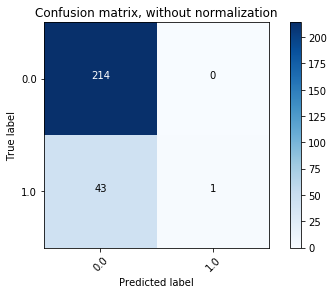


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0.0: 641, 1.0: 131}
	Classes in ytest: {0.0: 214, 1.0: 44}
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.99
	Accuracy on test data:     0.83
	
METRICS FOR TRAINING DATA
	Precision: 1.0
	Recall: 0.96
	F1 Score: 0.98
	Cohen's Kappa: 0.98


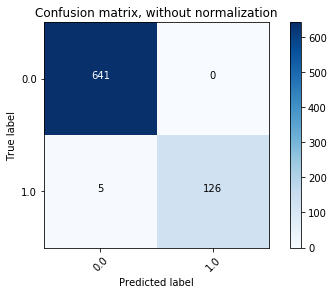

	Accuracy on training data: 0.99
	Accuracy on test data:     0.83
	
METRICS FOR TEST DATA
	Precision: 1.0
	Recall: 0.02
	F1 Score: 0.04
	Cohen's Kappa: 0.04


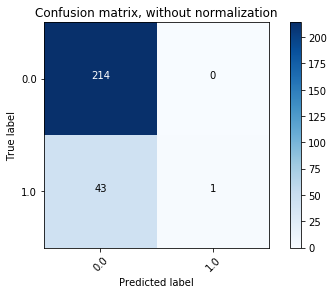


Y = SECUR2E (Someone took over social media account)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0.0: 598, 1.0: 92}
	Classes in ytest: {0.0: 200, 1.0: 31}
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.86
	
METRICS FOR TRAINING DATA
	Precision: 1.0
	Recall: 1.0
	F1 Score: 1.0
	Cohen's Kappa: 1.0


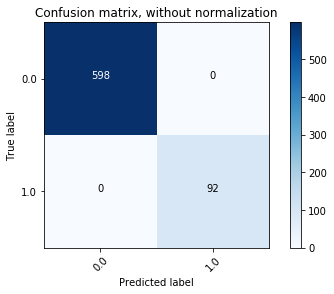

	Accuracy on training data: 1.00
	Accuracy on test data:     0.86
	
METRICS FOR TEST DATA
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: -0.01


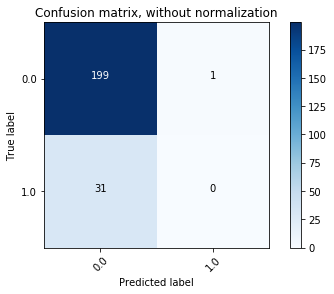


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0.0: 598, 1.0: 92}
	Classes in ytest: {0.0: 200, 1.0: 31}
	Best Parameters: {'C': 1, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.99
	Accuracy on test data:     0.87
	
METRICS FOR TRAINING DATA
	Precision: 1.0
	Recall: 0.95
	F1 Score: 0.97
	Cohen's Kappa: 0.97


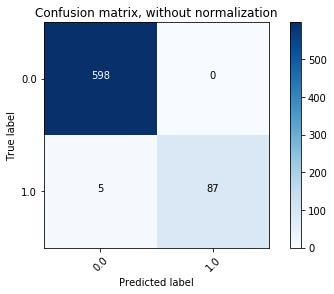

	Accuracy on training data: 0.99
	Accuracy on test data:     0.87
	
METRICS FOR TEST DATA
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


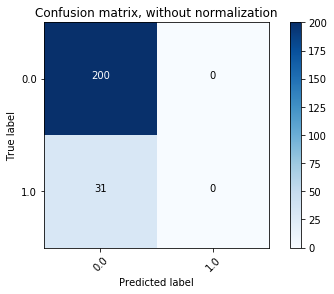


Y = SECUR2F (Someone opened line of credit/applied for loan under name)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0.0: 653, 1.0: 115}
	Classes in ytest: {0.0: 218, 1.0: 38}
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.85
	
METRICS FOR TRAINING DATA
	Precision: 1.0
	Recall: 1.0
	F1 Score: 1.0
	Cohen's Kappa: 1.0


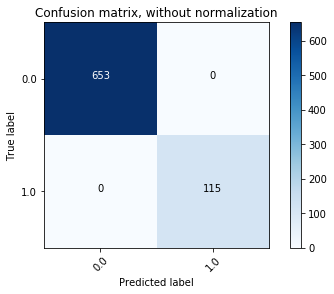

	Accuracy on training data: 1.00
	Accuracy on test data:     0.85
	
METRICS FOR TEST DATA
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


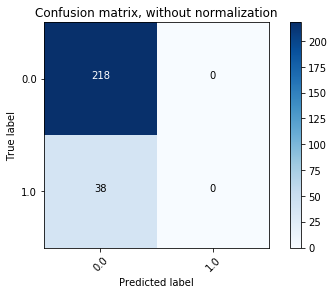


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0.0: 653, 1.0: 115}
	Classes in ytest: {0.0: 218, 1.0: 38}
	Best Parameters: {'C': 1, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.96
	Accuracy on test data:     0.85
	
METRICS FOR TRAINING DATA
	Precision: 1.0
	Recall: 0.72
	F1 Score: 0.84
	Cohen's Kappa: 0.82


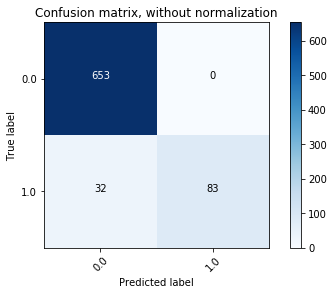

	Accuracy on training data: 0.96
	Accuracy on test data:     0.85
	
METRICS FOR TEST DATA
	Precision: 0.5
	Recall: 0.03
	F1 Score: 0.05
	Cohen's Kappa: 0.04


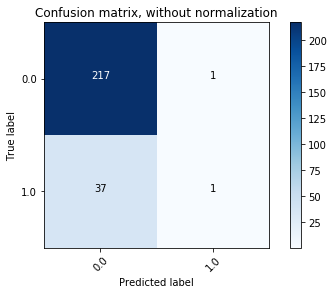


Y = SECUR2G (Someone received tax refund under name)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0.0: 727, 1.0: 43}
	Classes in ytest: {0.0: 243, 1.0: 14}
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.95
	
METRICS FOR TRAINING DATA
	Precision: 1.0
	Recall: 1.0
	F1 Score: 1.0
	Cohen's Kappa: 1.0


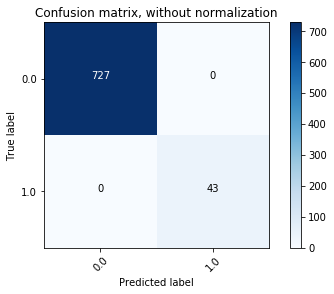

	Accuracy on training data: 1.00
	Accuracy on test data:     0.95
	
METRICS FOR TEST DATA
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


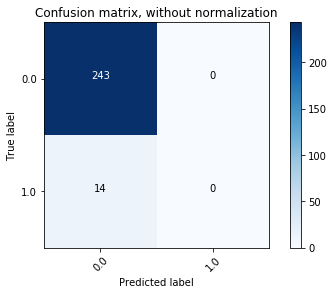


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0.0: 727, 1.0: 43}
	Classes in ytest: {0.0: 243, 1.0: 14}
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.98
	Accuracy on test data:     0.95
	
METRICS FOR TRAINING DATA
	Precision: 1.0
	Recall: 0.7
	F1 Score: 0.82
	Cohen's Kappa: 0.81


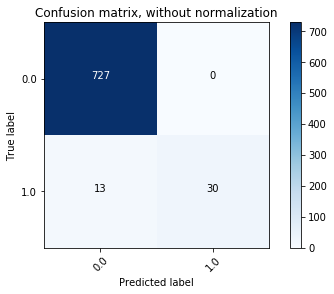

	Accuracy on training data: 0.98
	Accuracy on test data:     0.95
	
METRICS FOR TEST DATA
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


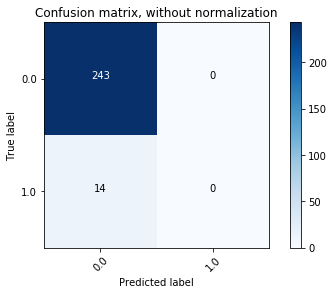

In [30]:
from sklearn.svm import SVC

clf_str = 'SVC'
mod_results = []

# create dictionary of parameters
dict_params = {'C': [10**0.1, 10**0, 10**1],
               'gamma': [10**0, 10**0.1, 10**1]}

# set scoring method for cv_optimize (Cohen's Kappa)
scorer = metrics.make_scorer(metrics.cohen_kappa_score)

""" ======= ITERATE THROUGH SECURITY INCIDENT COLUMNS ======= """
for y_col in sec_cols:

    if y_col != 'ID':
        
        print('\nY = ' + y_col.upper() + ' (' + dict_sec_cols[y_col] + ')')
        
        # remove rows where y_col is don't know/refused (0)
        clf_df = df[df[y_col] != 0]        
        
        
        # remove ID from dem_cols
        x_cols = dem_cols[1:]
        x_col_set = 'dem'

        """ ======= PERFORM SVM W/ DEMOGRAPHIC VARIABLES AS FEATURES ======= """

        print('\n\tX = DEMOGRAPHIC VARIABLES') 
        mod_results = do_classify(clf=SVC(), 
                                  parameters=dict_params, 
                                  df=clf_df,
                                  x_col_set = x_col_set,
                                  feature_names=x_cols,
                                  targetname=y_col,
                                  scorer=scorer,
                                  mod_results=mod_results,
                                  clf_str=clf_str)

        # remove ID from hab_cols
        x_cols = hab_cols[1:]  
        x_col_set = 'hab'
        
        """ ======= PERFORM SVM W/ SECURITY HABITS VARIABLES AS FEATURES ======= """
        
        print('\n\tX = SECURITY HABIT VARIABLES')
        mod_results = do_classify(clf=SVC(), 
                                  parameters=dict_params, 
                                  df=clf_df,
                                  x_col_set = x_col_set,
                                  feature_names=x_cols,
                                  targetname=y_col,
                                  scorer=scorer,
                                  mod_results=mod_results,
                                  clf_str=clf_str)
        
        curr_mod_results = pd.DataFrame(mod_results) 

# rearrange results column order
curr_mod_results = reorder_cols(curr_mod_results)

# add results to final results dataframe
if 'df_mod_results' not in locals(): df_mod_results = create_final_df()

df_mod_results = df_mod_results.append(curr_mod_results)

<div class="alert alert-success">
<h1>FINAL MODEL RESULTS</h1>
</div>

In [31]:
for key, val in dict_sec_cols.items():
    print(key,val)

secur2a SSN compromised
secur2b Other sensitive info compromised
secur2c Fraudulent charges on credit/debit card
secur2d Someone took over email
secur2e Someone took over social media account
secur2f Someone opened line of credit/applied for loan under name
secur2g Someone received tax refund under name


In [32]:
pd.set_option('display.max_rows', 100)
df_mod_results.sort_values(by=['X','y'])

,y,X,clf,best_params,score_meth,acc_train,precision_train,recall_train,f1_train,cohenk_train,auc_train,acc_test,precision_test,recall_test,f1_test,cohenk_test,auc_test
0,secur2a,dem,logreg,"{'C': 0.01, 'class_weight': {0: 0.2, 1: 0.8}, ...",cohenk,0.81,0.24,0.10,0.14,0.05,0.59,0.80,0.26,0.14,0.18,0.08,0.62
0,secur2a,dem,knn,{'n_neighbors': 1},cohenk,1.00,1.00,1.00,1.00,1.00,1.00,0.75,0.24,0.26,0.25,0.10,0.55
0,secur2a,dem,RF,"{'min_samples_split': 9, 'n_estimators': 1}",cohenk,0.83,0.47,0.35,0.40,0.31,0.78,0.76,0.21,0.17,0.19,0.05,0.54
0,secur2a,dem,SVC,"{'C': 1.2589254117941673, 'gamma': 1}",cohenk,1.00,1.00,1.00,1.00,1.00,-999.00,0.84,0.00,0.00,0.00,0.00,-999.00
2,secur2b,dem,logreg,"{'C': 0.01, 'class_weight': {0: 0.4, 1: 0.6}, ...",cohenk,0.59,0.48,0.59,0.53,0.17,0.62,0.57,0.46,0.57,0.51,0.14,0.64
2,secur2b,dem,knn,{'n_neighbors': 5},cohenk,0.73,0.67,0.62,0.64,0.43,0.78,0.64,0.55,0.47,0.50,0.22,0.66
2,secur2b,dem,RF,"{'min_samples_split': 5, 'n_estimators': 30}",cohenk,0.97,0.98,0.93,0.96,0.93,1.00,0.61,0.51,0.30,0.37,0.12,0.63
2,secur2b,dem,SVC,"{'C': 1.2589254117941673, 'gamma': 1}",cohenk,1.00,1.00,0.99,1.00,0.99,-999.00,0.61,0.00,0.00,0.00,0.00,-999.00
4,secur2c,dem,logreg,"{'C': 0.1, 'class_weight': {0: 0.5, 1: 0.5}, '...",cohenk,0.63,0.61,0.56,0.59,0.26,0.69,0.59,0.56,0.54,0.55,0.18,0.64
4,secur2c,dem,knn,{'n_neighbors': 15},cohenk,0.67,0.67,0.56,0.61,0.33,0.72,0.63,0.59,0.58,0.59,0.24,0.65


## Save results

In [ ]:
import os 

path = '/Users/Rachel/Desktop'
filename = 'df_mod_results_30Sep17.txt'
fullpath = os.path.join(path, filename)
df_mod_results.to_csv(fullpath, sep='\t', encoding='utf-8', index = False)